In [1]:
import sys
import os
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from adjoint_esn.esn import ESN
from adjoint_esn.utils import preprocessing as pp
from pathlib import Path
from adjoint_esn.rijke_galerkin.solver import Rijke
from scipy.integrate import odeint
from adjoint_esn.utils import signals as sig

In [2]:
def run_rijke_sim(beta,tau,N_g,t_sim_len,data_dt,data_path=None):
    my_rijke = Rijke(N_g=N_g,N_c=10,c_1=0.1,c_2=0.06,beta=beta,x_f=0.2,tau=tau,
                     heat_law="kings_poly",damping="modal")
    
    if data_path is None:
        y0 = np.zeros(my_rijke.N_dim+1)
        y0[0] = 1.0 
        
        # Temporal grid
        t_sim = np.arange(0, t_sim_len+data_dt, data_dt)

        # Solve ODE using odeint
        y_sim = odeint(my_rijke.ode, y0, t_sim, tfirst=True)
    else:
        data_dict = pp.read_h5(data_path)
        y_sim = data_dict["y"]
        t_sim = data_dict["t"]

    #gal_idx = np.arange(2 * my_rijke.N_g+my_rijke.N_c)
    #gal_idx = gal_idx.tolist()

    gal_idx = np.arange(2 * my_rijke.N_g)
    gal_idx = gal_idx.tolist()
    gal_idx.append(2 * my_rijke.N_g+my_rijke.N_c-1)
    U_sim = y_sim[:, gal_idx]
                       
    #u_f_tau_sim = y_sim[:,my_rijke.N_c-1]
    #q_sim = np.zeros((len(u_f_tau_sim),1))
    #for idx,u_f_tau in enumerate(u_f_tau_sim):
    #    if abs(u_f_tau + 1.0) < 0.01:
    #        coeffs = np.array([-1.0, 0.0, 1.75e3, 6.2e-12, -7.5e6])
    #        poly = np.poly1d(coeffs[::-1])
    #        q_sim[idx] = poly(1.0 + u_f_tau)
    #    else:
    #        q_sim[idx] = (np.sqrt(np.abs(1.0 + u_f_tau)) - 1.0)
    #U_sim = np.hstack((y_sim[:, gal_idx],q_sim))
    return y_sim, U_sim, t_sim

def create_dataset(U_sim,t_sim,dt,
                   t_transient_len,
                   t_washout_len,
                   t_train_len,
                   t_val_len):
    data_dt=t_sim[1]-t_sim[0]

    # upsample
    upsample = int(np.round(dt/data_dt))
    U = U_sim[::upsample,:]
    t = t_sim[::upsample]

    # cut the transient    
    N_transient = int(np.round(t_transient_len/dt))
    U = U[N_transient:,:]
    t = t[N_transient:]-t[N_transient]

    # separate into washout, train, val
    N_washout = int(np.round(t_washout_len/dt))
    N_train = int(np.round(t_train_len/dt))
    N_val = int(np.round(t_val_len/dt))

    U_washout_train = U[0:N_washout,:]

    U_train = U[N_washout:N_washout+N_train-1,:]
    Y_train = U[N_washout+1:N_washout+N_train,:]
    t_train = t[N_washout+1:N_washout+N_train]

    U_washout_val = U[N_washout+N_train:2*N_washout+N_train,:]
    U_val = U[2*N_washout+N_train:2*N_washout+N_train+N_val-1,:]
    Y_val = U[2*N_washout+N_train+1:2*N_washout+N_train+N_val,:]
    t_val = t[2*N_washout+N_train+1:2*N_washout+N_train+N_val]

    return U_washout_train, U_train, Y_train, t_train, U_washout_val, U_val, Y_val, t_val

def load_data_sys(beta,tau,N_g,t_sim_len,data_dt,dt,
                   t_transient_len,
                   t_washout_len,
                   t_train_len,
                   t_val_len,data_path=None):
    _, U_sim, t_sim = run_rijke_sim(beta,tau,N_g,t_sim_len,data_dt,data_path)
    U_washout_train, U_train, Y_train, t_train, U_washout_val, U_val, Y_val, t_val = create_dataset(U_sim,t_sim,dt,
                   t_transient_len,
                   t_washout_len,
                   t_train_len,
                   t_val_len)
    return U_washout_train, U_train, Y_train, t_train, U_washout_val, U_val, Y_val, t_val


In [4]:
sim_dict = {"t_sim_len": 500,
            "data_dt": 1e-2,
            "dt": 1e-2,
            "t_transient_len": 200,
            "t_washout_len": 4,
            "t_train_len": 200,
            "t_val_len": 40,
            }

param = "beta"
p_list = [1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]
#p_list = [1.0,2.0,3.0,4.0,5.0]
N_g = 4
len_p_list = len(p_list)
U_washout_train = [None]*len_p_list
U_train = [None]*len_p_list
Y_train = [None]*len_p_list
t_train = [None]*len_p_list
U_washout_val = [None]*len_p_list
U_val = [None]*len_p_list
U_val = [None]*len_p_list
Y_val = [None]*len_p_list
t_val = [None]*len_p_list

for p_idx, p in enumerate(p_list):
    if param == "beta":
        beta = p
        print("Beta:", beta)
        tau = 0.2
    elif param == "tau":
        tau = p
        print("Tau:", tau)
        beta = 1.2

    beta_name = f'{beta:.2f}'
    beta_name = beta_name.replace(".","_")
    tau_name = f'{tau:.2f}'
    tau_name = tau_name.replace(".","_")
    data_path = f"data_new/rijke_kings_poly_N_g_4_beta_{beta_name}_tau_{tau_name}.h5"

    (U_washout_train[p_idx], 
     U_train[p_idx], 
     Y_train[p_idx], 
     t_train[p_idx], 
     U_washout_val[p_idx], 
     U_val[p_idx], 
     Y_val[p_idx], 
     t_val[p_idx]) = load_data_sys(beta=beta,tau=tau,N_g=N_g,
                                    **sim_dict,data_path=data_path)
    
    dim = U_train[0].shape[1]
    periods = np.array([sig.period(U_train[p_idx][:,i], sim_dict["dt"]) for i in range(dim)])
    print("Periods: ", periods)
    print("Period steps:", np.round(periods/sim_dict["dt"]))

P_washout_train = [None]*len_p_list
P_train = [None]*len_p_list
P_washout_val = [None]*len_p_list
P_val = [None]*len_p_list
P_mean = np.array(np.mean(p_list))

for p_idx in range(len_p_list):
    P_washout_train[p_idx] = p_list[p_idx]*np.ones((len(U_washout_train[p_idx]),1))
    P_train[p_idx] = p_list[p_idx]*np.ones((len(U_train[p_idx]),1))
    P_washout_val[p_idx] = p_list[p_idx]*np.ones((len(U_washout_val[p_idx]),1))
    P_val[p_idx] = p_list[p_idx]*np.ones((len(U_val[p_idx]),1))

Beta: 1.0
Periods:  [1.95 1.95 1.95 1.95 1.95 1.95 1.95 1.95 1.95]
Period steps: [195. 195. 195. 195. 195. 195. 195. 195. 195.]
Beta: 1.5
Periods:  [1.96 1.96 1.96 1.96 1.96 1.96 1.96 1.96 1.96]
Period steps: [196. 196. 196. 196. 196. 196. 196. 196. 196.]
Beta: 2.0
Periods:  [1.96 1.96 1.96 1.96 1.96 1.96 1.96 1.96 1.96]
Period steps: [196. 196. 196. 196. 196. 196. 196. 196. 196.]
Beta: 2.5
Periods:  [1.96 1.96 1.96 1.96 1.96 1.96 1.96 1.96 1.96]
Period steps: [196. 196. 196. 196. 196. 196. 196. 196. 196.]
Beta: 3.0
Periods:  [1.95 1.95 1.95 1.95 1.95 1.95 1.95 1.95 1.95]
Period steps: [195. 195. 195. 195. 195. 195. 195. 195. 195.]
Beta: 3.5
Periods:  [1.95 1.95 1.95 1.95 1.95 1.95 1.95 1.95 1.95]
Period steps: [195. 195. 195. 195. 195. 195. 195. 195. 195.]
Beta: 4.0
Periods:  [1.95 1.95 1.95 1.95 1.95 1.95 1.95 1.95 1.95]
Period steps: [195. 195. 195. 195. 195. 195. 195. 195. 195.]
Beta: 4.5
Periods:  [1.94 1.94 1.94 1.94 1.94 1.94 1.94 1.94 1.94]
Period steps: [194. 194. 194. 194. 19

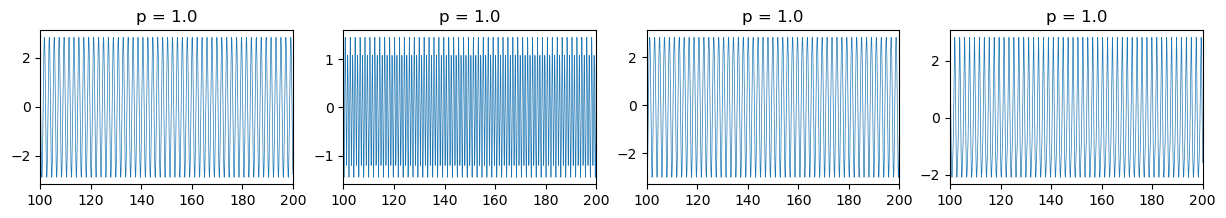

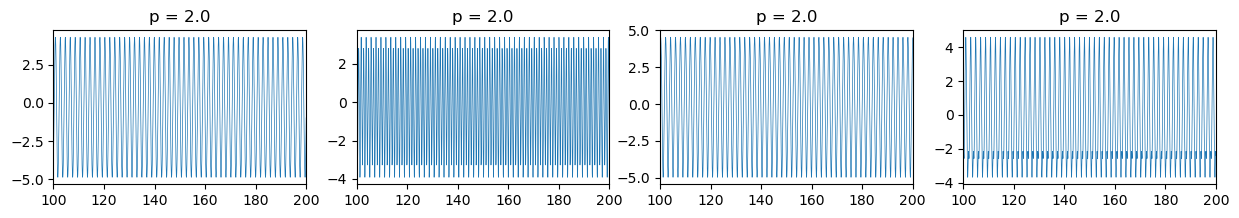

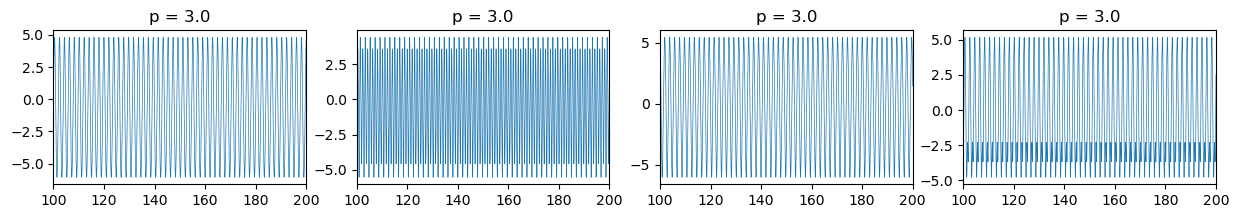

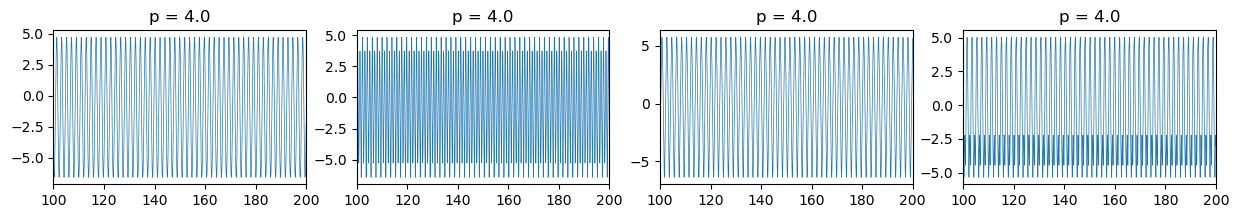

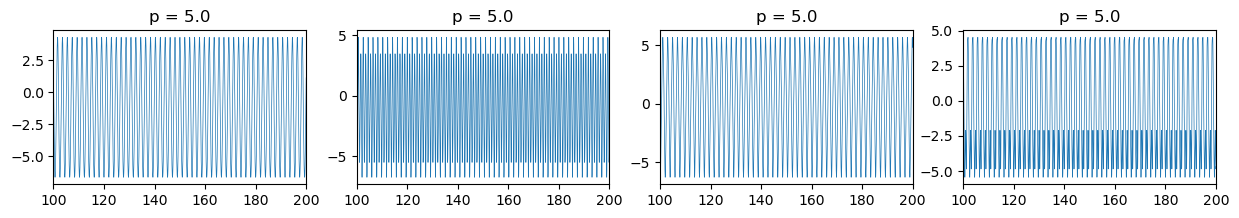

In [4]:
for p_idx in range(len_p_list):
    plt.figure(figsize = (15,2))
    for j, k in enumerate([0,1,N_g,-1]):
        plt.subplot(1,4,j+1)
        plt.plot(t_train[p_idx],U_train[p_idx][:,k],linewidth=0.5)
        plt.title(f"p = {p_list[p_idx]}")
        plt.ylabel(f"")
        plt.xlim([100,200])

In [77]:
U_mean = np.mean(np.vstack(U_train),axis = 0)
#U_mean = np.zeros(len(U_mean))
U_std = np.std(np.vstack(U_train),axis = 0)
m = np.vstack(U_train).min(axis=0)
M = np.vstack(U_train).max(axis=0)
U_norm = M-m 
scale = (U_mean, U_std)

input_bias = np.array([np.mean(np.abs((U_train[0]-scale[0])/scale[1]))])

In [5]:
scale

[None, None]

In [6]:
scale = [None]*2
scale[0] = np.zeros(dim)
scale[1] = np.ones(dim)

In [18]:
from adjoint_esn.validation_v2 import validate as validate_v2

#range for hyperparameters (spectral radius and input scaling)
spec_in     = 0.1  
spec_end    = 1.0
in_scal_in  = np.log10(0.01)
in_scal_end = np.log10(1.0)
leak_in     = 0.1    
leak_end    = 1.0
param_var_in = 1.0
param_var_end = 10.0
param_mean_in = 0.0
param_mean_end = 10.0
grid_range = [[spec_in, spec_end],[in_scal_in, in_scal_end],[leak_in, leak_end],[param_mean_in, param_mean_end],[param_var_in, param_var_end]]
# In case we want to start from a grid_search, 
# the first n_grid_x*n_grid_y points are from grid search
param_names = ['spectral_radius','input_scaling','leak_factor','parameter_normalization_mean','parameter_normalization_var']
param_scales = ['uniform','log10','uniform','uniform','uniform']
N_washout = 100
N_val = 800
N_transient = 0
reservoir_sizes = [400]
connectivities = [20]
min_dicts = [[None]*1]*1
for r_idx, reservoir_size in enumerate(reservoir_sizes):
    for c_idx, connectivity in enumerate(connectivities):
        print("Reservoir size", reservoir_size, "Connectivity", connectivity)
        ESN_dict = {'reservoir_size': reservoir_size, 
                    'dimension' : dim, 
                    'parameter_dimension' : 1,
                    'reservoir_connectivity' : connectivity,
                    'input_normalization': scale, 
                    'input_bias' : np.array([0.0]),
                    'output_bias' : np.array([0.0]),
                    'parameter_normalization': [np.array([0.0]),np.array([1.0])],
                    'r2_mode': True,
                    }
        min_dict = validate_v2(grid_range,param_names,param_scales,
            n_calls = 100, n_initial_points = 100, n_ensemble = 1,
            ESN_dict = ESN_dict, tikh = 1e-3, 
            U_washout_train = U_washout_train,
            U_train = U_train,
            U_val = U_val,
            Y_train = Y_train,
            Y_val = Y_val,
            P_washout_train = P_washout_train,
            P_train = P_train,
            P_val = P_val,
            n_folds = 5,
            n_realisations=3,
            N_washout_steps = N_washout,
            N_val_steps = N_val,
            N_transient_steps = N_transient,
            train_idx_list = [0,1,2,3,4],
            val_idx_list = [0,1,2,3,4])
        min_dicts[r_idx][c_idx] = min_dict

Reservoir size 400 Connectivity 20
Running 1/1 of ensemble.
--NEW RUN-- 1
spectral_radius 0.6335601564025166
input_scaling 0.4881255012149711
leak_factor 0.8721510558604813
parameter_normalization_mean 8.472517387841256
parameter_normalization_var 6.612073271073752


Realisation: 0
Val regime: 0
Val regime error: 31.834119542180968
Val regime: 1
Val regime error: 35.20465910861306
Val regime: 2
Val regime error: 36.83522445914581
Val regime: 3
Val regime error: 39.297190285865526
Val regime: 4
Val regime error: 38.45398956258775
Realisation error: 181.6251829583931


Realisation: 1
Val regime: 0
Val regime error: 24.15026529440255
Val regime: 1
Val regime error: 29.314095285537597
Val regime: 2
Val regime error: 31.174792793461442
Val regime: 3
Val regime error: 34.43519799304056
Val regime: 4
Val regime error: 34.716972639095744
Realisation error: 153.7913240055379


Realisation: 2


KeyboardInterrupt: 

In [ ]:
# Notes:
# small input scaling, input can't drive the system anymore we get fixed point
# decrease tikhonov, then the weights are bigger, input can drive the system?

# input states not scaled
reservoir_size = 300, 
reservoir_connectivity = 3, 
spectral_radius = 0.4535063164907469,
input_scaling = 0.06856125576980092,
leak_factor = 0.40365654437554166,
parameter_normalization=[np.array([0.0]),np.array([1.0])],
train_list=[1,2,3,4]
tikh = 1e-1
# parameter_normalization_var = 1.0, limit cycle and fixed point after 4.0
# parameter_normalization_var = 5.0, start seeing quasiperiodic and chaotic after 4.0, but doesn't go to fixed point at 0.5, and doesn't fit 1.0 that well
# probably need to scale each input separately, probably that's the reason why the third mode's amplitude is small
# and at some point the system is dominated by the second mode and not first, but the esn predicts that the first mode is always dominant
# parameter normalization var determines the nonlinear transitions

train_list=[1,2,3,4,5]
tikh = 1
# the amplitude starts going down after the training range, if training until 5 then it starts going down after that, 
# if until 4 then after that and so on

# mapping from reservoir to input is learned by the readout, mapping from input to reservoir is random
# each mode contributes uniformly randomly, the mode coefficient determines which one is dominant 

reservoir_size = 1200, 
reservoir_connectivity = 20, 
spectral_radius = 0.6517571120957193,
input_scaling = 0.6378185800348745,
leak_factor = 0.1893523153230765,
parameter_normalization=[np.array([0.0]),np.array([10])],
train_list=[1,2,3,4,5]
tikh = 1e-1
# increasing input scale, it started capturing the higher modes
tikh = 1
# amplitudes are all wrong but it got chaos at 7, and back to limit cycle at 7.5
# at 0.5 it also predicts chaos instead of fixed point

reservoir_size = 1200, 
reservoir_connectivity = 20, 
spectral_radius = 0.82034062,
input_scaling = 0.56788701,
leak_factor = 0.18411351,
parameter_normalization=[np.array([4.2630588]),np.array([2.97317638])],
train_list=[1,2,3,4,5]
#tikh = 1e-1, limit cycles after 5.0
#tikh = 1e-3, got chaos at 7, wrong amplitude

reservoir_size = 1200, # reservoir sizes 400,800 work as well, seems to change where the bifurcation occurs?
reservoir_connectivity = 20, 
spectral_radius = 0.75460178,    
input_scaling = 0.68803003,
leak_factor = 0.15127487,
parameter_normalization=[np.array([8.88043705]),np.array([5.1122118])],
train_list=[1,2,3,4,5]
tikh = 1e-3

# things to look into: dense input weights, solver of the ridge regression, constraining the weights matrices
# what if you pass in the heat release law?
# what if you use pressure and velocity data instead? can we remove the delayed velocity at the flame? Can we add the heat release?
# subcritical bifurcation, hysteresis?
# calculating uf(t-tau) directly and giving it as an input to all inputs
# fixed point, floquet analyses?
# see if it can get the statistics of chaotic with less data
# condition number of the ESN, errors get amplified

reservoir_size = 1200, 
reservoir_connectivity = 20, 
spectral_radius = 0.6221774,
input_scaling = 0.52028844,
leak_factor = 0.12436209,
parameter_normalization=[np.array([7.3139734]),np.array([5.84740945])],
train_list=[1,2,3,4,5,6,8,9]
tikh = 1e-3 # seems to capture the dynamics, but then also converge to other attractors depending on the washout

reservoir_size = 1200,
reservoir_connectivity = 20, 
spectral_radius = 0.18094057, 
input_scaling = 0.92818257,
leak_factor = 0.16492563,
parameter_normalization=[np.array([0.21703727]),np.array([9.44680754])],
train_list=[1,2,3,4,5,6,7,8,9]
tikh = 1e-3, # can now interpolate between quasi, chaotic, except for 7.5 something weird happens, doesn't capture the bifurcation to fixed point either

reservoir_size = 1200, 
reservoir_connectivity = 20, 
spectral_radius = 0.22719225,      
input_scaling = 0.85547937,
leak_factor =  0.16353361, 
parameter_normalization=[np.array([0.08923826]),np.array([10.])]
tikhonov = 1e-3

reservoir_size = 1200, 
reservoir_connectivity = 20, 
spectral_radius = 0.23649333,                     
input_scaling = 0.88227934,
leak_factor = 0.11399726,
parameter_normalization=[np.array([0.33222385,]),np.array([9.84317464])],
tikhonov = 1e-3


reservoir_size = 1200, 
reservoir_connectivity = 20, 
spectral_radius = 0.20160398,                           
input_scaling = 0.84537455,
leak_factor = 0.19066498,
parameter_normalization=[np.array([0.1263459]),np.array([9.80440781])],
input_seeds=[11,12,45]
reservoir_seeds=[41,53]
tikhonov = 1e-3 #bifn to fixed point 0.95
tikhonov = 3e-3 #bifn to fixed point 0.9

In [7]:
print('System dimension: ', dim)
my_ESN = ESN(reservoir_size = 1200, 
            dimension = dim, 
            parameter_dimension = 1, 
            reservoir_connectivity = 20, 
            spectral_radius = 0.75460178,    
            input_scaling = 0.68803003,
            leak_factor = 0.15127487,
            input_bias = np.array([]),
            output_bias = np.array([]),
            input_normalization = scale, 
            parameter_normalization=[np.array([8.88043705]),np.array([5.1122118])],
            r2_mode=True,
            input_seeds=[11,12,45],
            reservoir_seeds=[41,53])

System dimension:  9
Input normalization is changed, training must be done again.
Parameter normalization is changed, training must be done again.
Input scaling is set to 1, set it separately if necessary.
Input weights are rescaled with the new input scaling.
Spectral radius is set to 1, set it separately if necessary.
Reservoir weights are rescaled with the new spectral radius.


In [8]:
my_ESN.train(U_washout_train, U_train, Y_train, tikhonov = 1e-3, P_washout=P_washout_train, P_train=P_train, train_idx_list=[0,2,4,6,8])

In [9]:
def L2_error(y, y_pred):
    return np.linalg.norm(y-y_pred, 'fro')

def log10_error(y, y_pred):
    return np.log10(np.mean((y-y_pred)**2))

def col_mse(y_true, y_pred):
    return np.mean((y_true-y_pred)**2, axis = 0)

def mse(y_true, y_pred):
    return np.sum(col_mse(y_true, y_pred))

def rmse(y_true, y_pred):
    return np.sum(np.sqrt(col_mse(y_true, y_pred)))

def nrmse(y_true, y_pred):
    col_maxmin = np.max(y_true, axis=0)-np.min(y_true, axis=0)
    col_rmse = np.sqrt(col_mse(y_true, y_pred))
    return np.sum(col_rmse/col_maxmin)

In [ ]:
for p_idx in range(len_p_list):
    _, Y_pred_train_ = my_ESN.closed_loop_with_washout(U_washout = U_washout_train[p_idx], N_t = len(U_train[p_idx]), P_washout=P_washout_train[p_idx], P = P_train[p_idx])
    Y_pred_train = Y_pred_train_[1:,:]
    est_velocity = Rijke.toVelocity(N_g, eta=Y_pred_train[:,0:N_g], x=np.array([0.2])) 

    plt.figure(figsize=(15,4))
    plt.plot(t_train[p_idx], Y_train[p_idx][:,-1], color ='silver',linewidth = 4)
    plt.plot(t_train[p_idx], Y_pred_train[:,-1],color ='black',linewidth = 1)
    plt.plot(t_train[p_idx][20:], est_velocity[:-20,0],color ='tab:orange',linestyle ='--')
    plt.xlim([175,200])
    plt.title(f"p = {p_list[p_idx]}")
    plt.xlabel("t")
    plt.ylabel("u_f(t-tau)")
    plt.legend(["True","Pred","Est"])

    plt.figure(figsize=(15,4))
    plt.plot(t_train[p_idx], Y_train[p_idx][:,-1]-Y_pred_train[:,-1],color ='black',linewidth = 1)
    plt.plot(t_train[p_idx][20:],Y_train[p_idx][20:,-1]-est_velocity[:-20,0] ,color ='tab:orange',linestyle ='--')
    plt.title(f"p = {p_list[p_idx]}")
    plt.xlim([175,200])
    plt.ylabel("u_f(t-tau) error")
    plt.legend(["Pred","Est"])

    plt.figure(figsize=(15,4))
    plt.plot(t_train[p_idx][20:],Y_pred_train[20:,-1]-est_velocity[:-20,0] ,color ='tab:blue')
    plt.title(f"p = {p_list[p_idx]}")
    plt.xlim([175,200])
    plt.ylabel(["u_f(t-tau) pred-est"])

C:\Users\egeoz\AppData\Local\Temp\ipykernel_6040\3712311788.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(20,4), constrained_layout = True)


Train error:  0.0028703759982329855
Validation error:  0.002783728320751481
Train error:  15.417056021495062
Validation error:  4.523388462909287
Train error:  0.0033515192635502223
Validation error:  0.002933167794094088
Train error:  9.864335999435509
Validation error:  2.110133833785943
Train error:  0.0033861305122983285
Validation error:  0.003051980311310006
Train error:  6.729030663738095
Validation error:  1.3508354232928843
Train error:  0.003661344020004133
Validation error:  0.003404570179850212
Train error:  7.881640595091192
Validation error:  1.5903814415078794
Train error:  0.0037753218290625884
Validation error:  0.003668380288865965


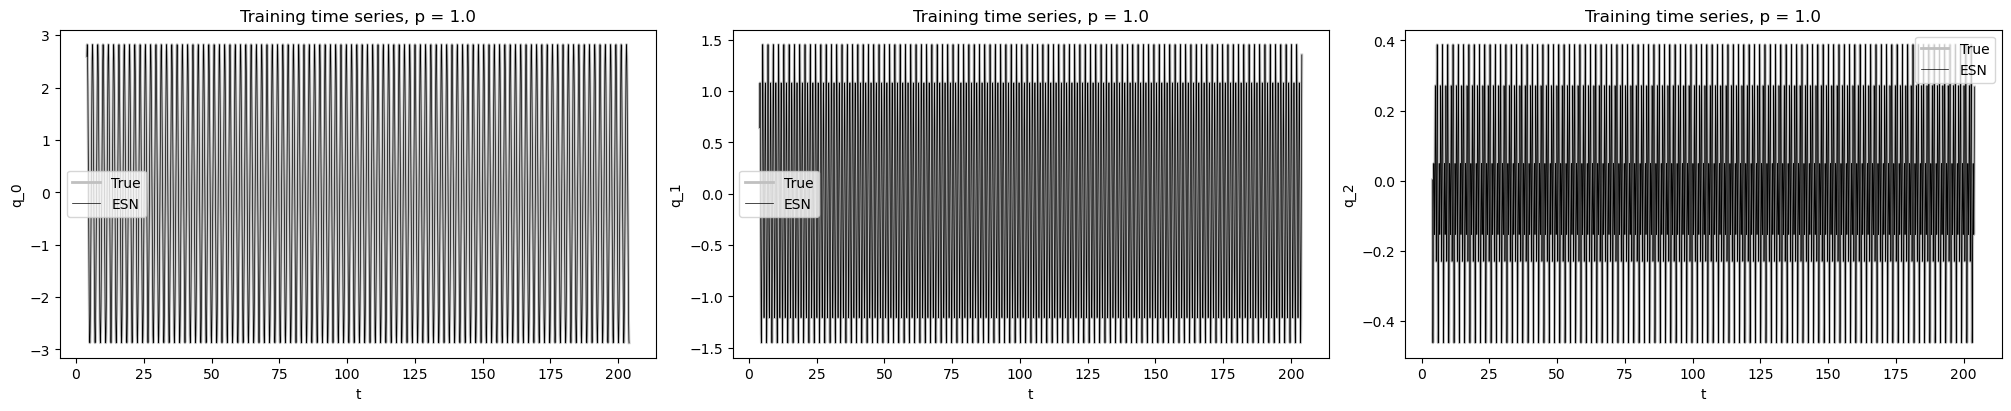

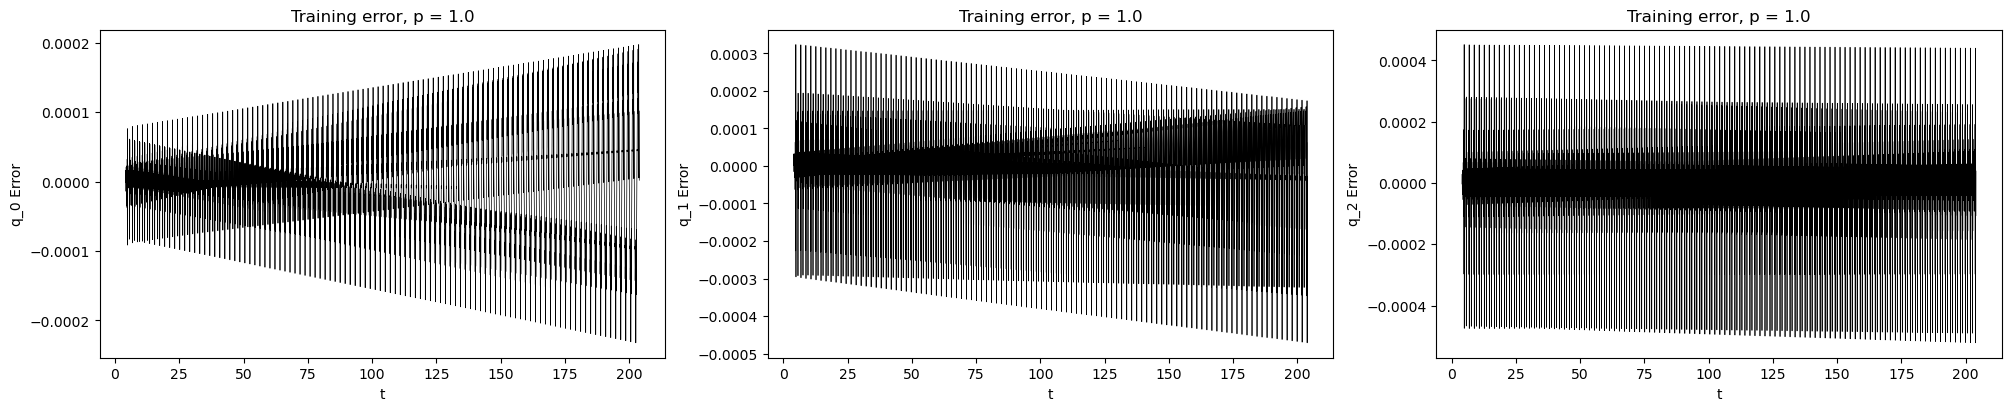

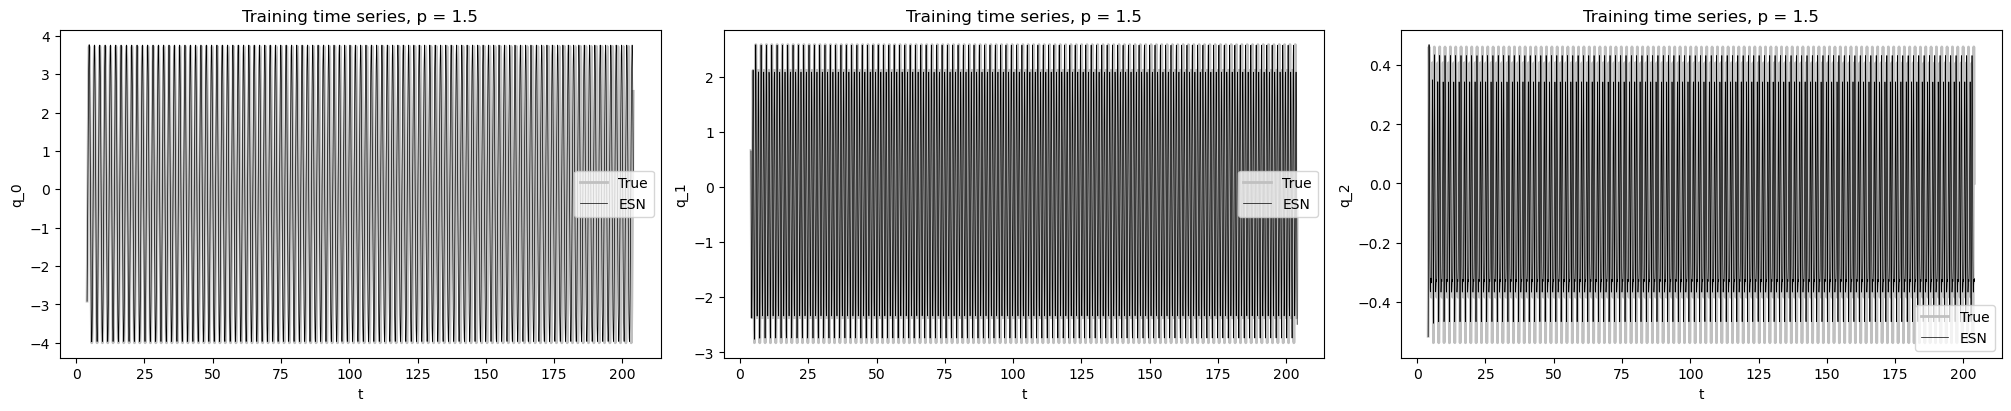

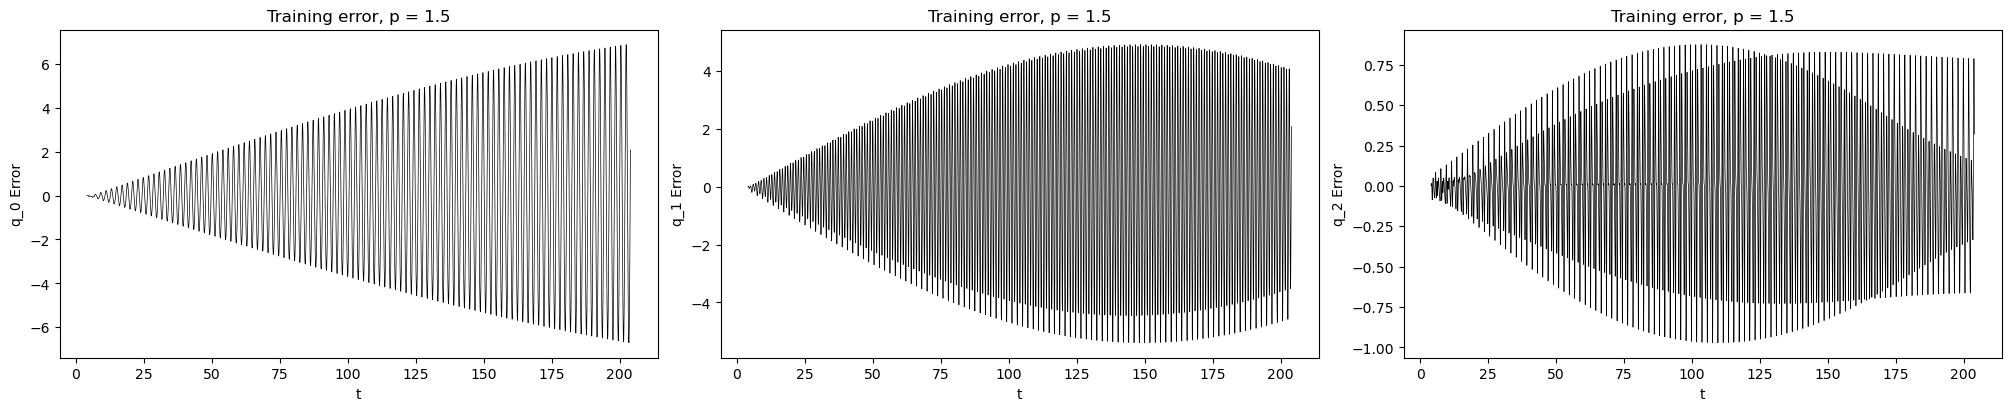

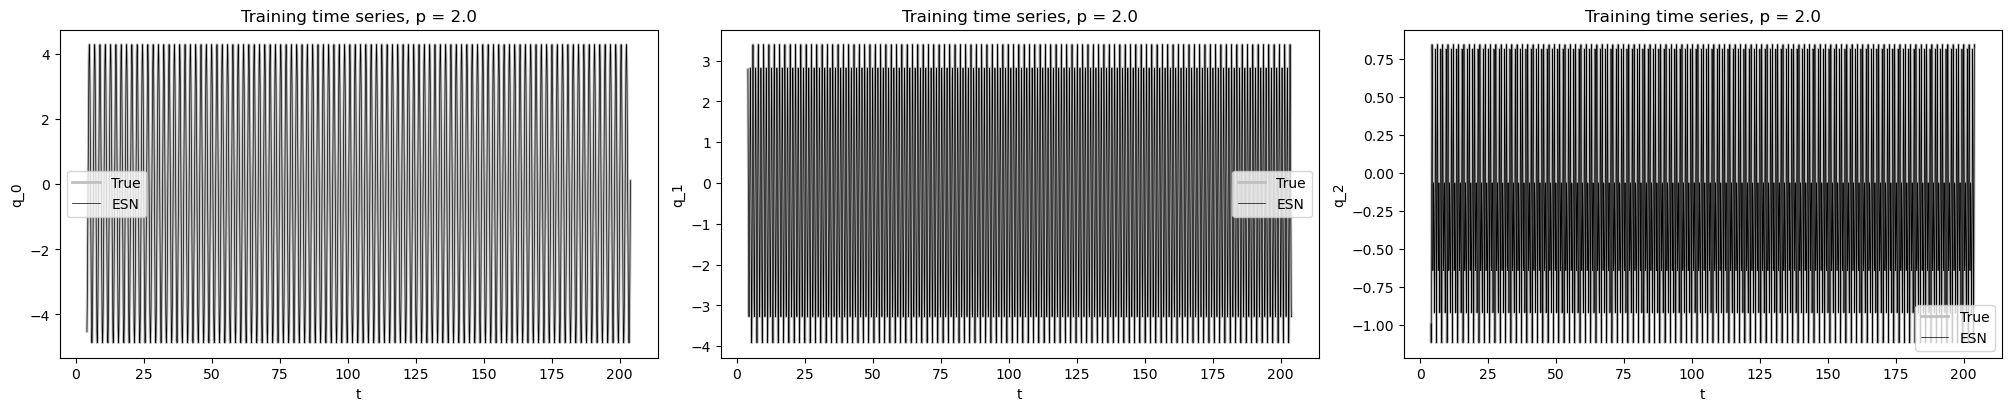

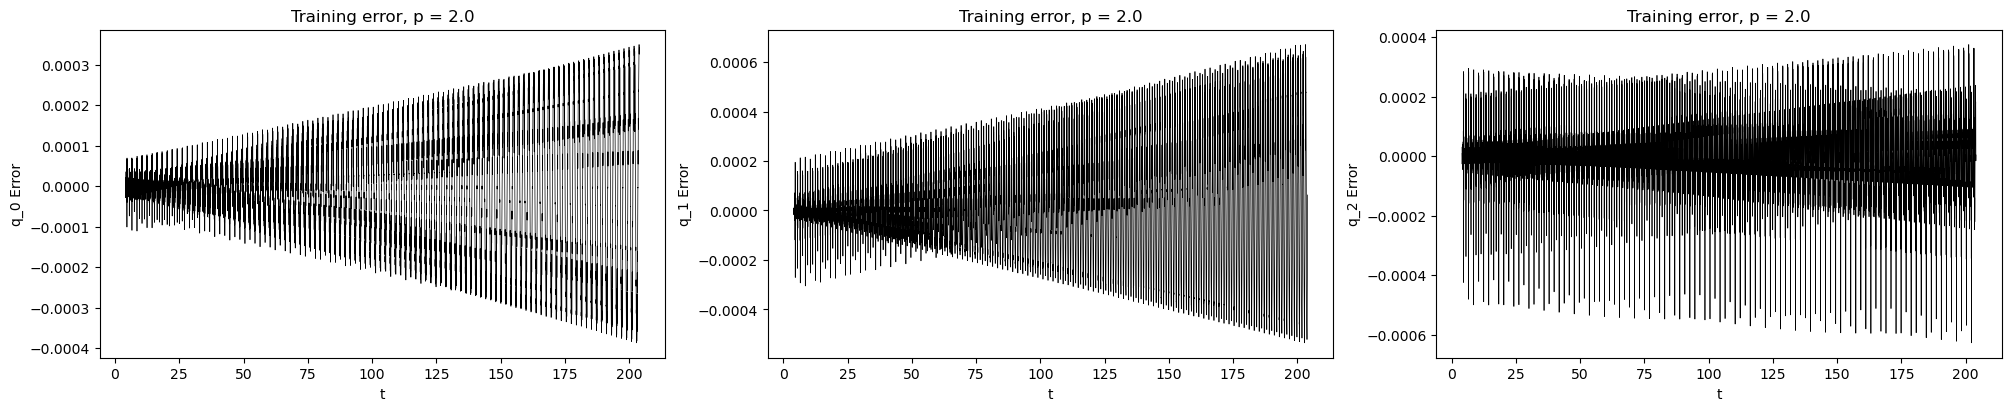

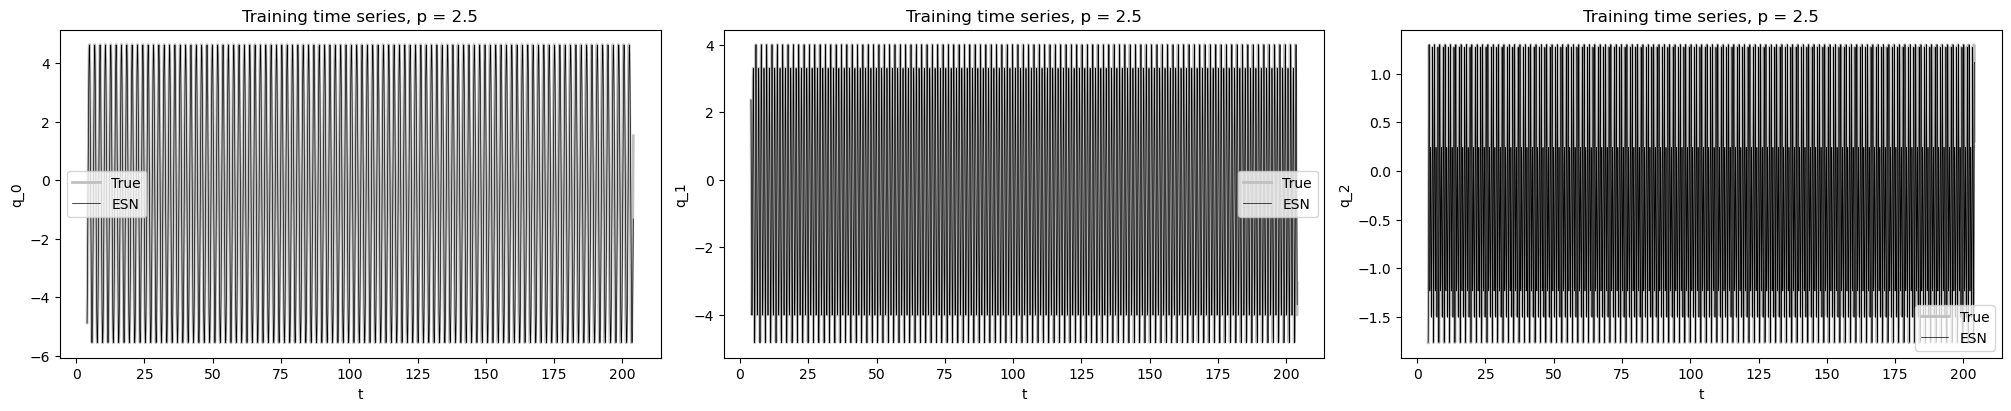

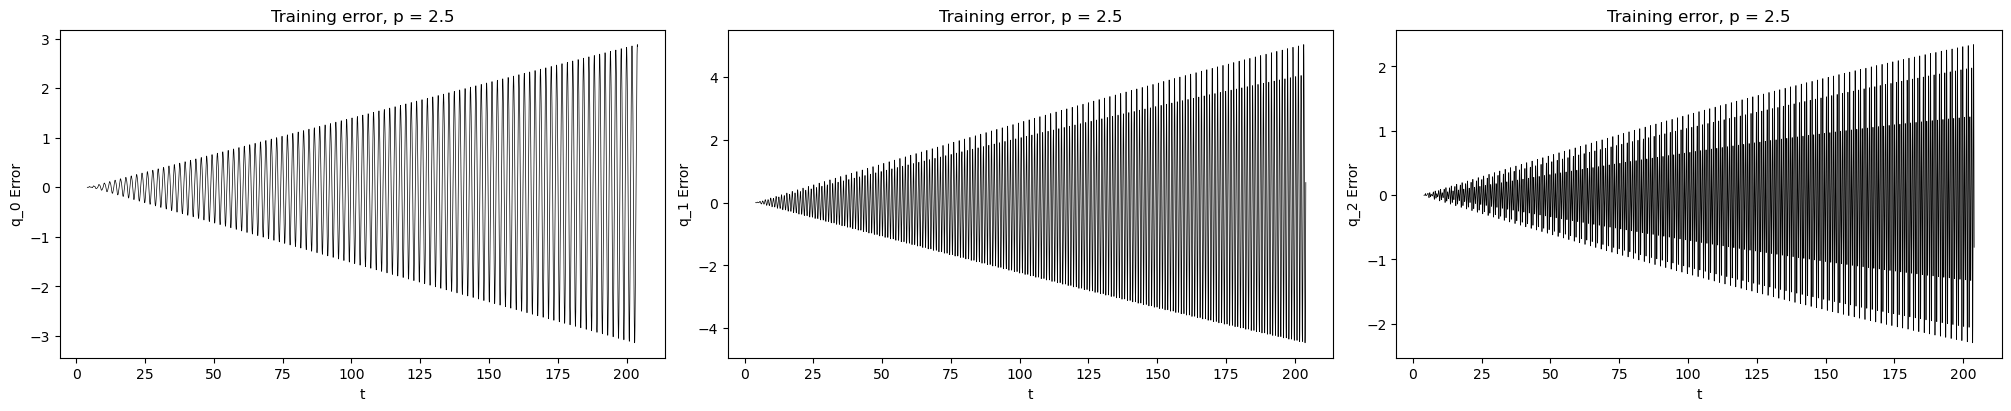

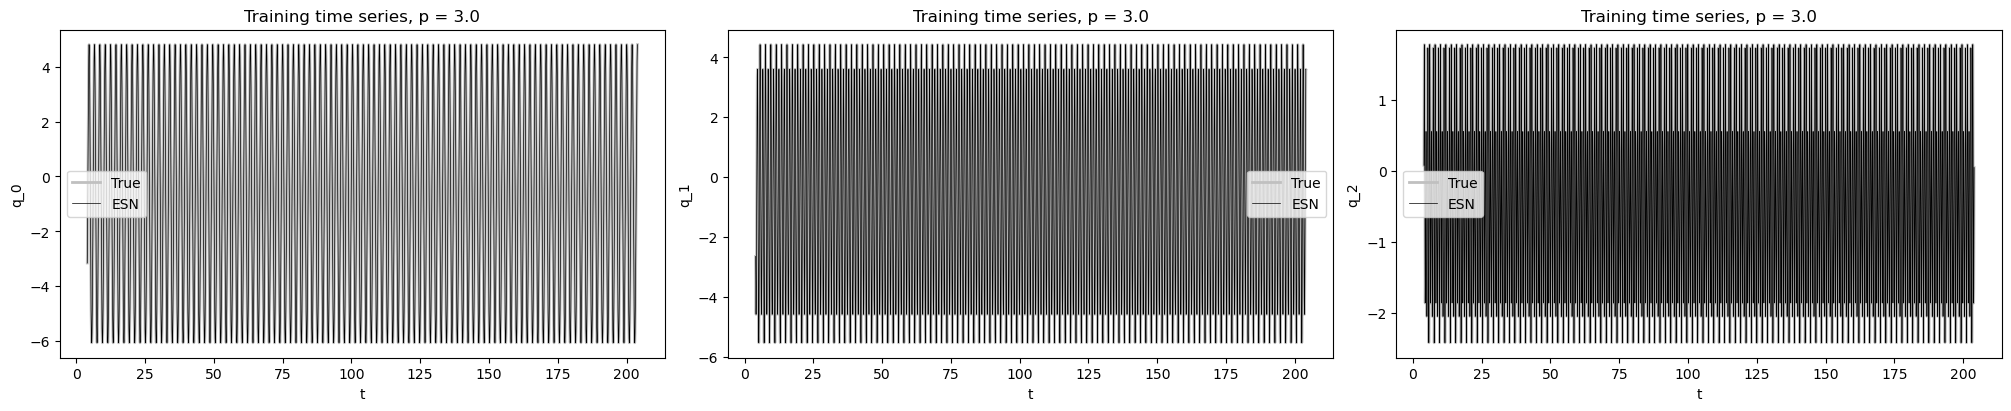

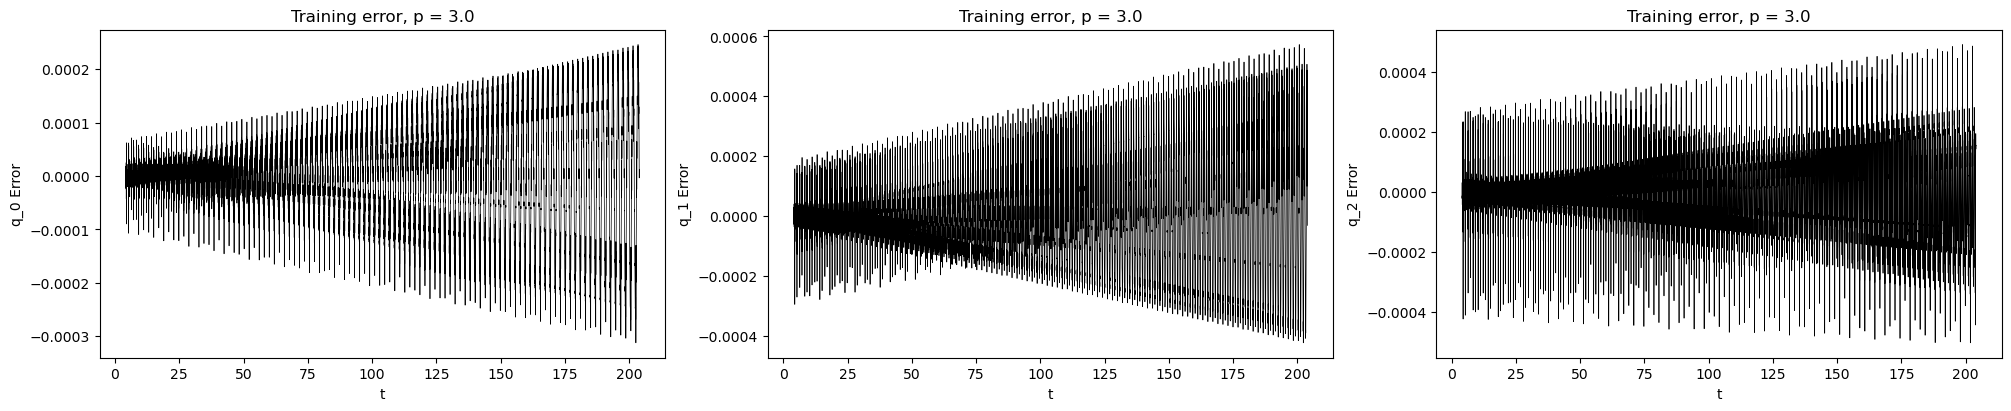

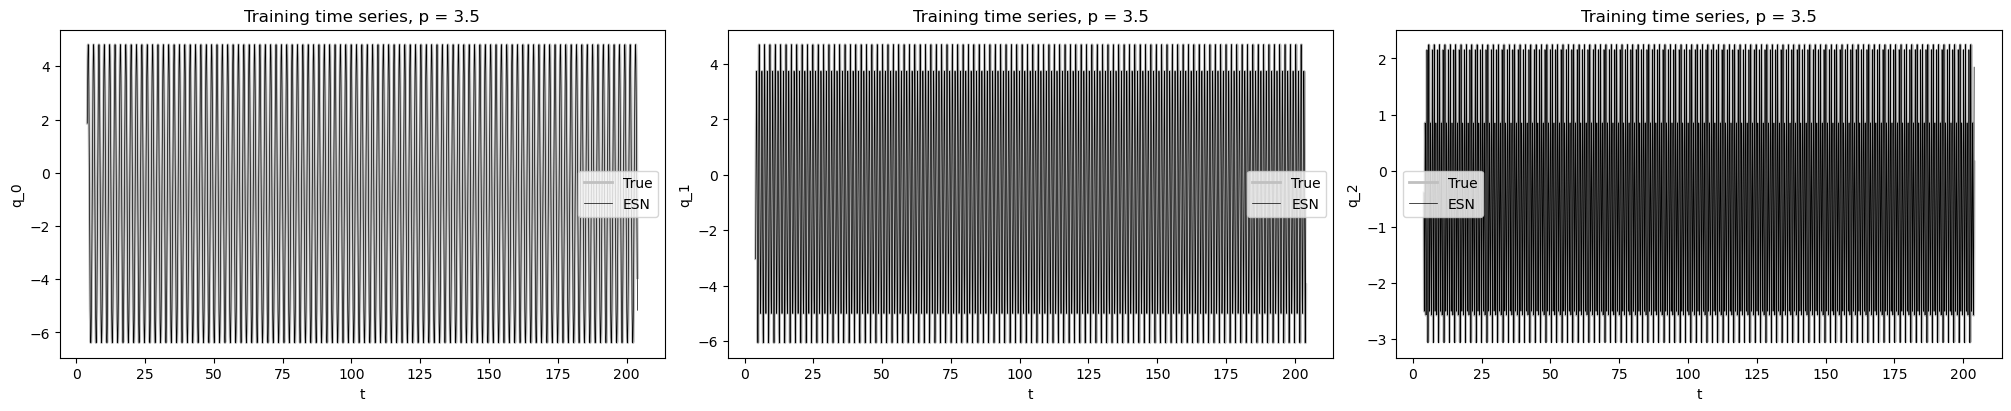

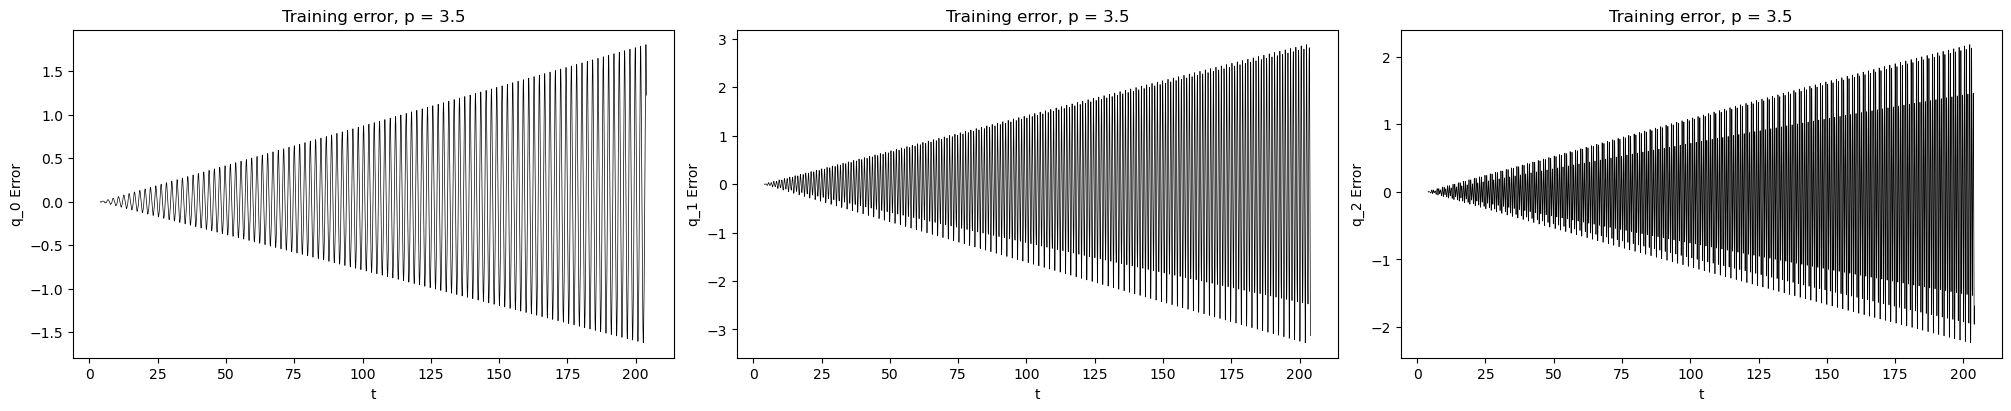

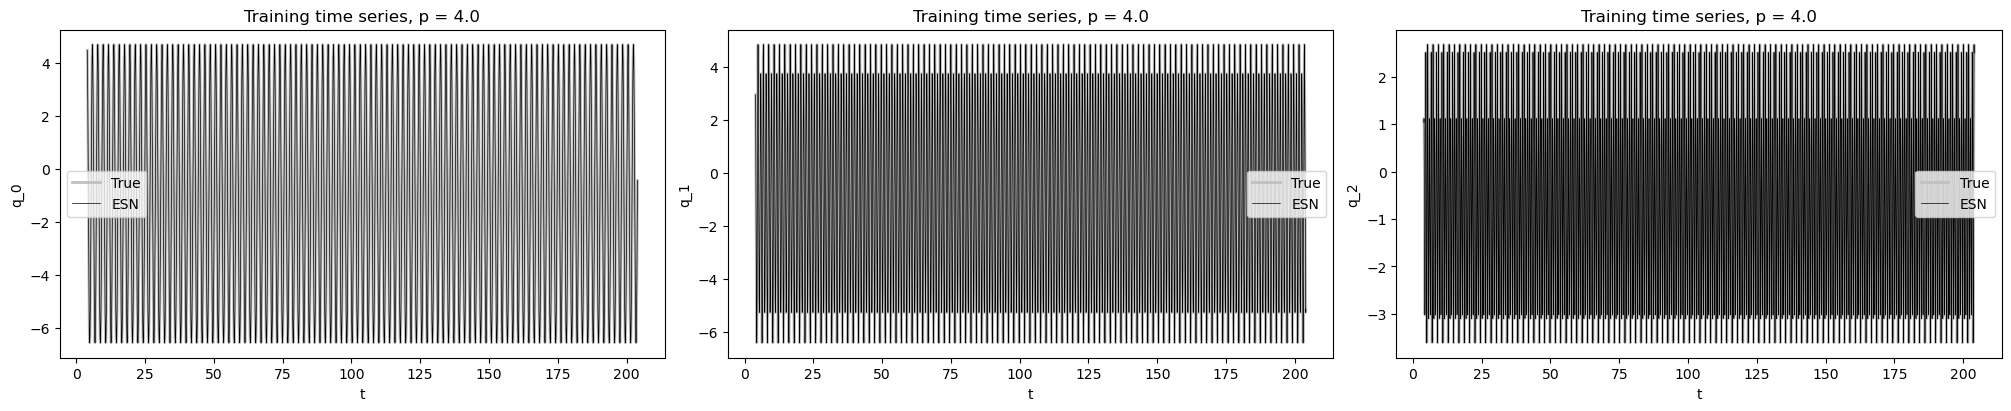

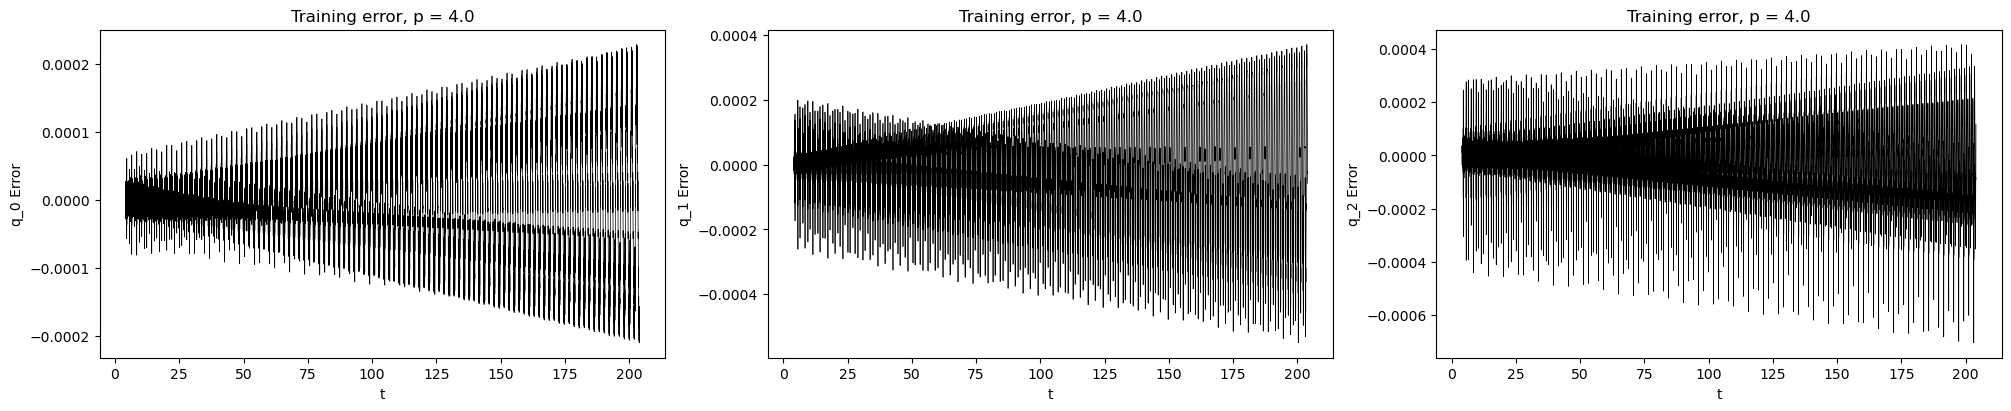

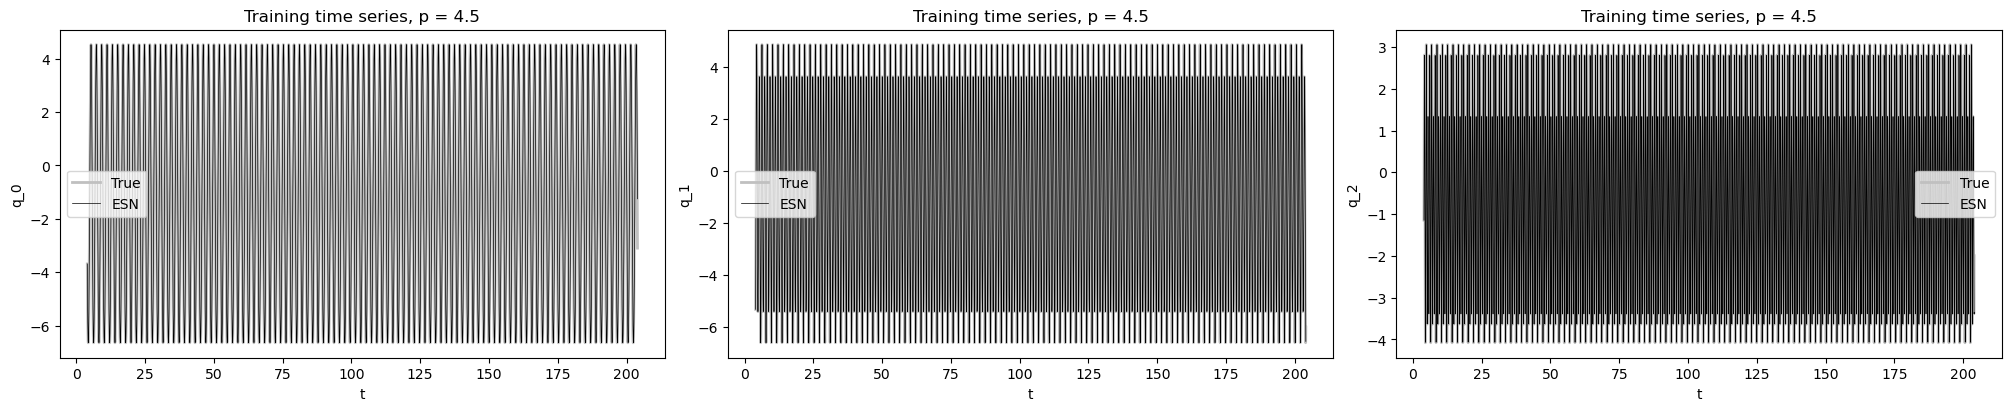

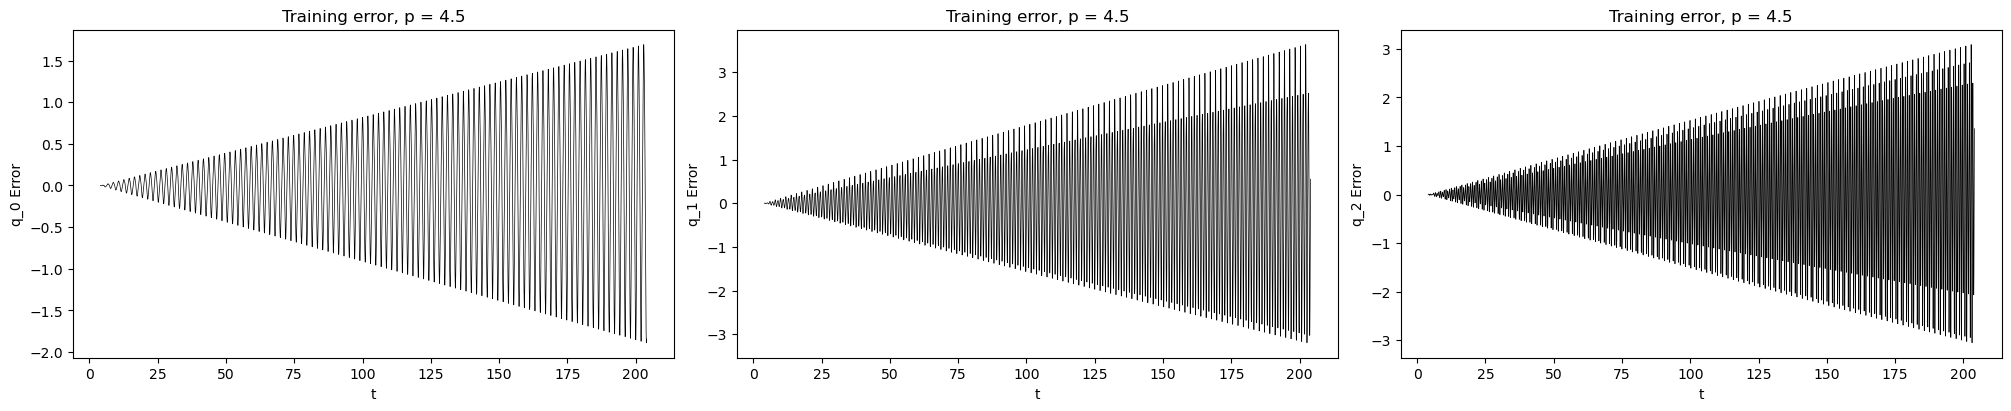

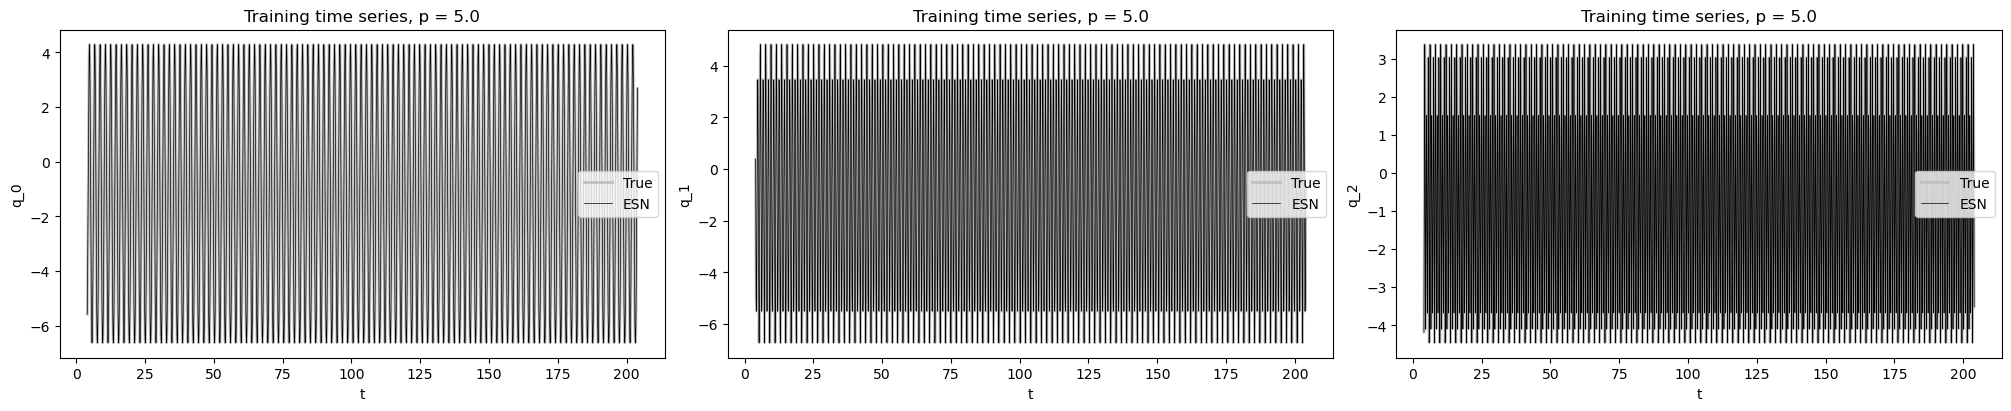

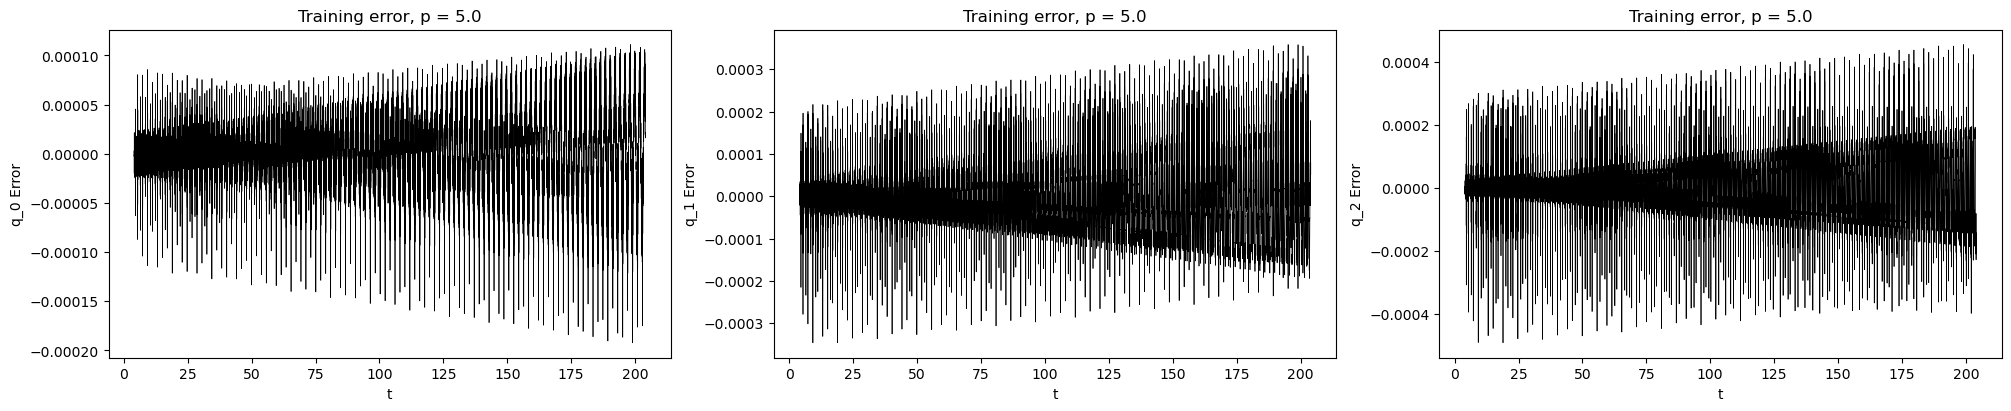

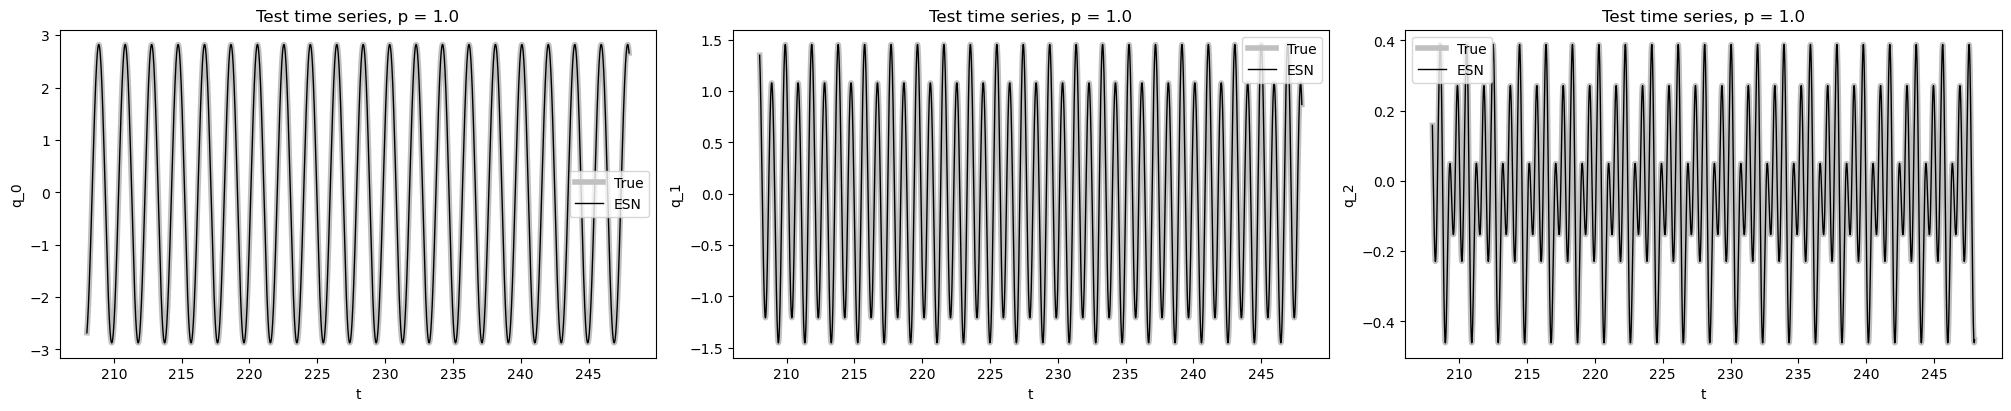

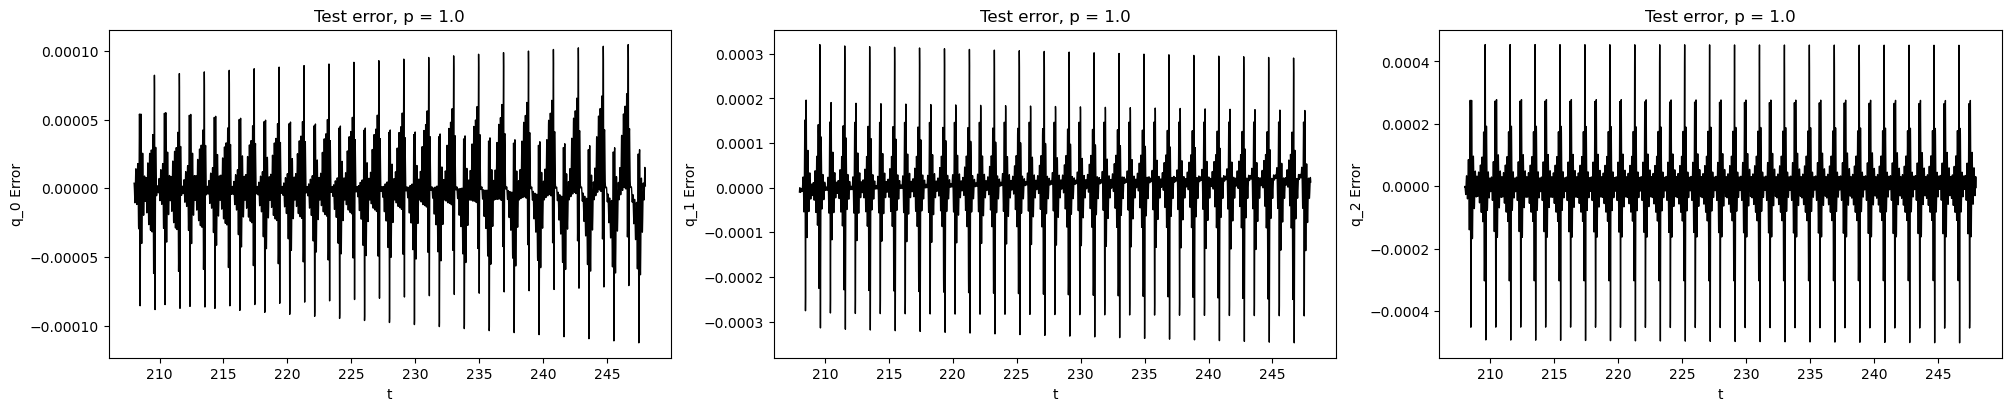

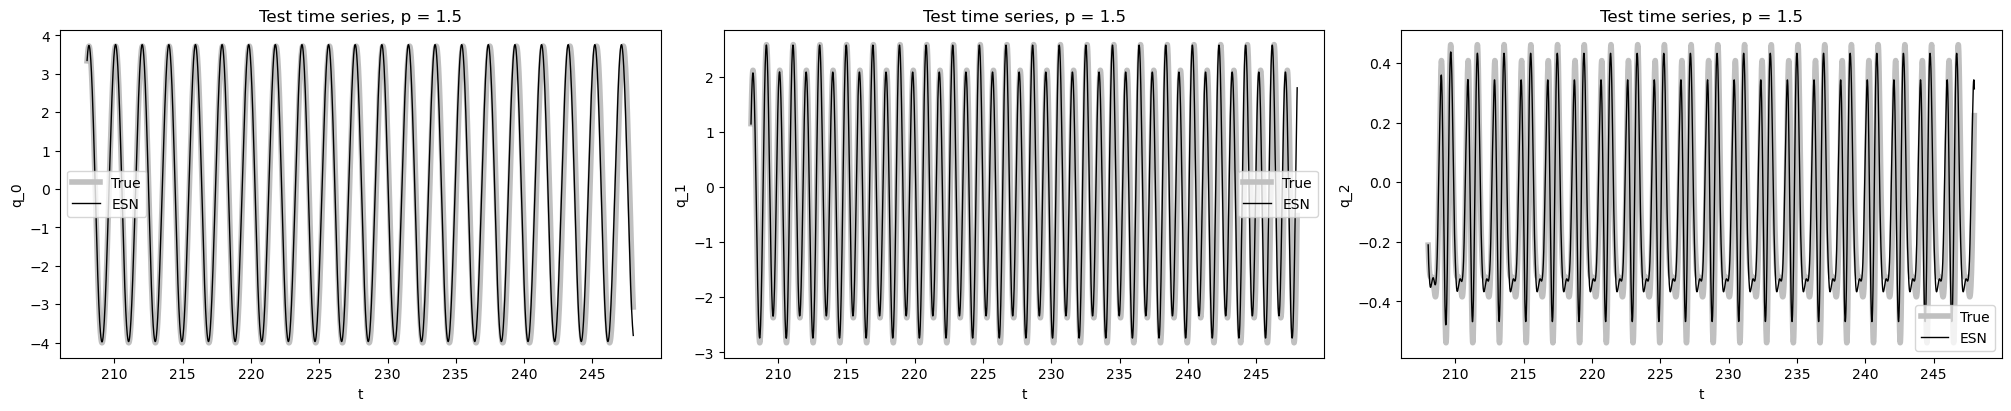

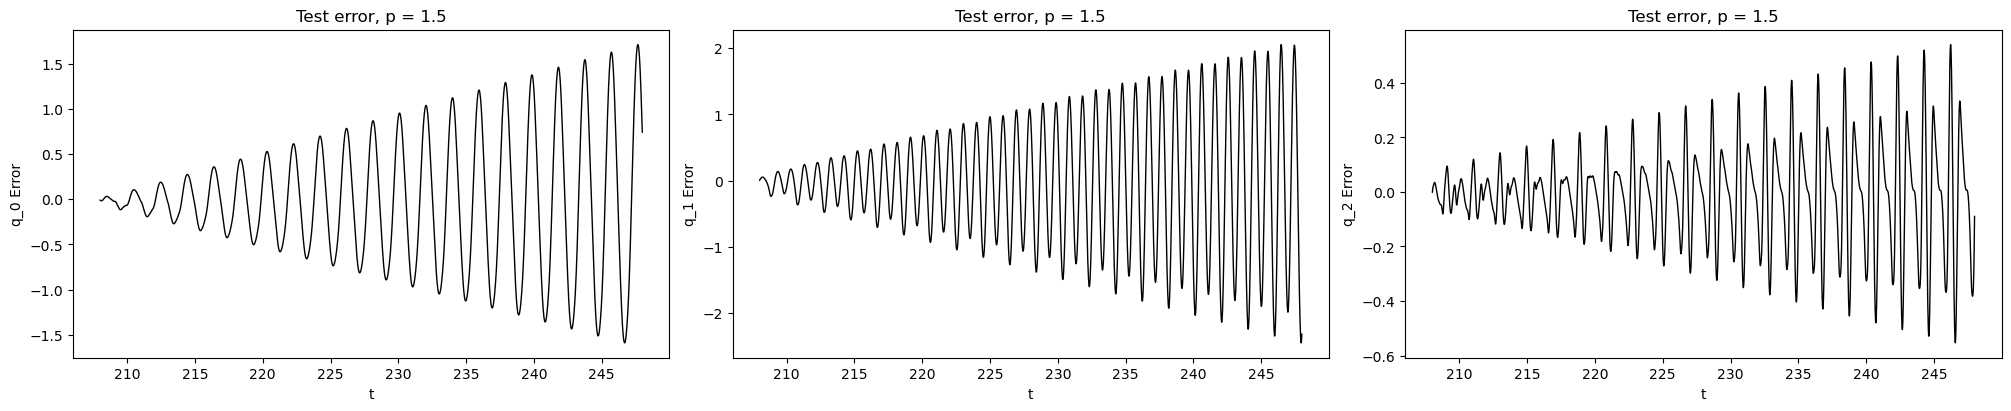

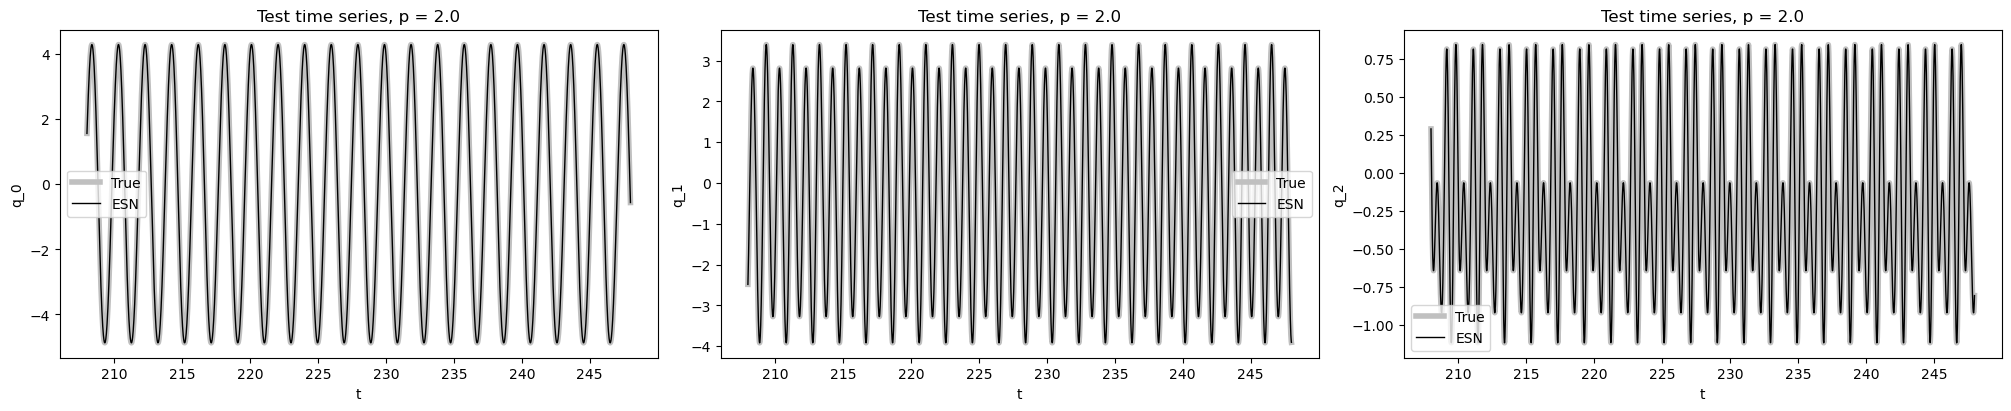

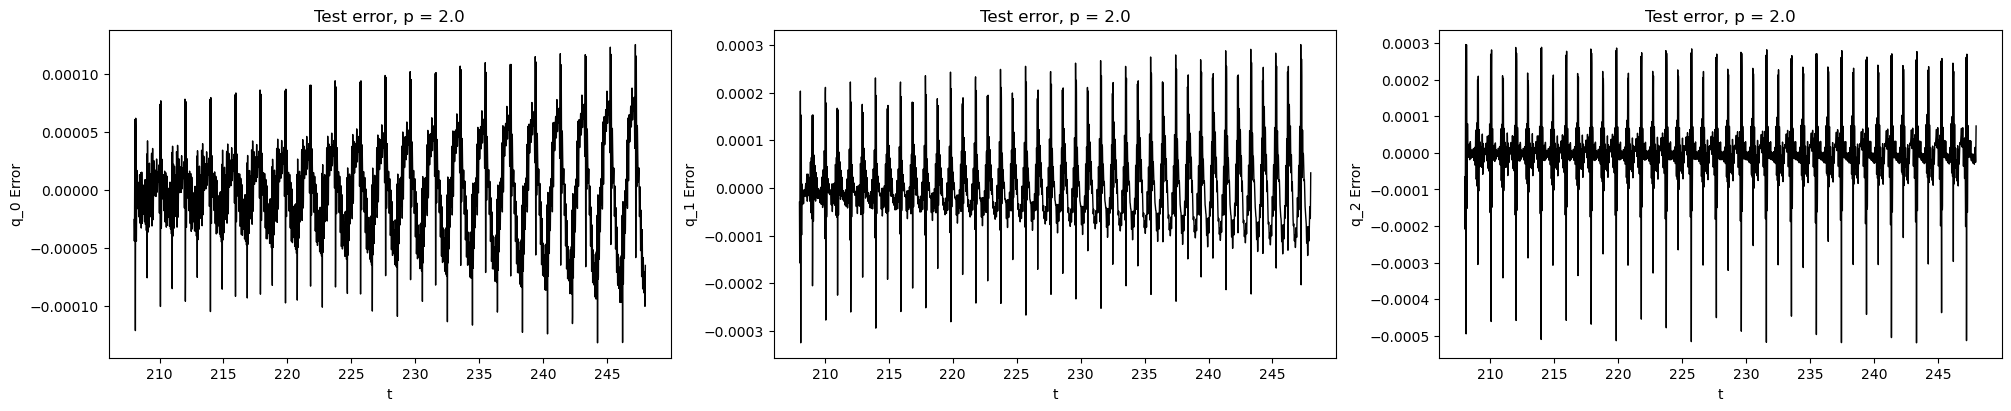

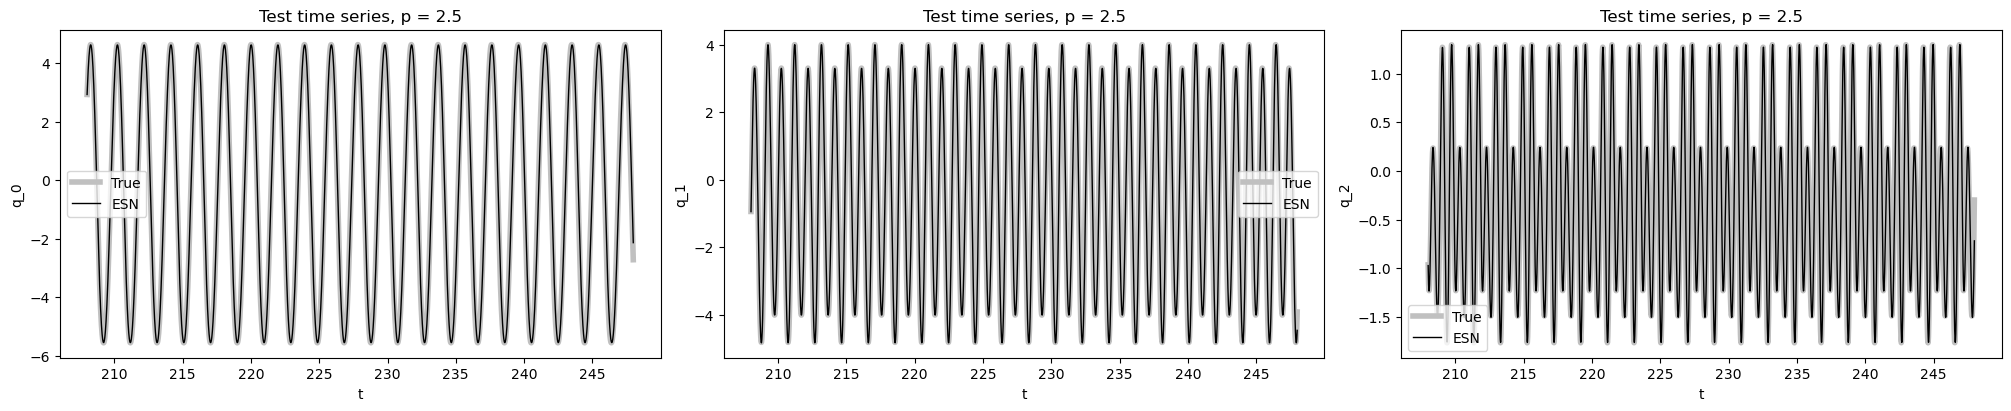

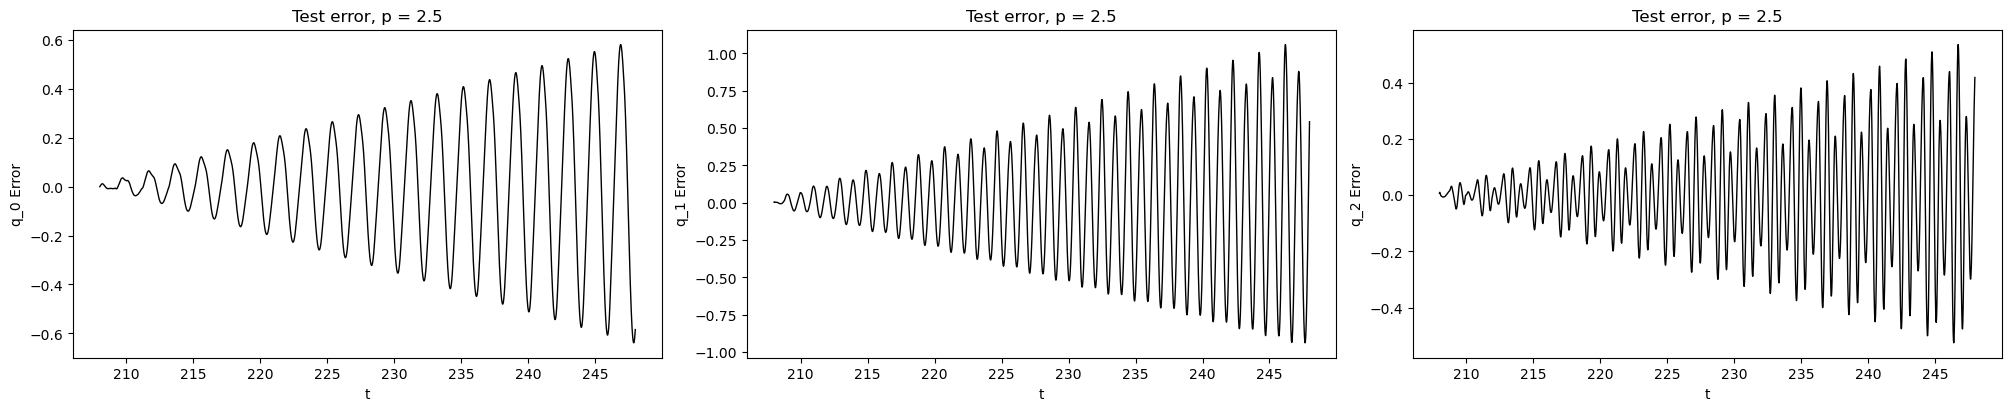

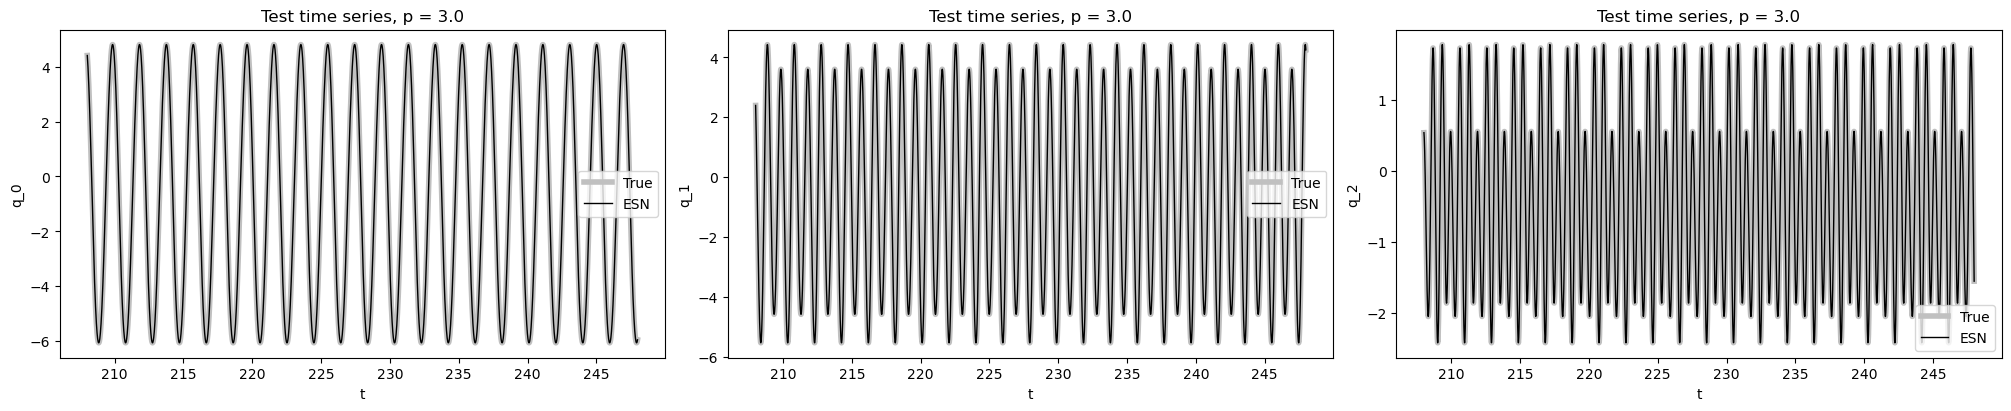

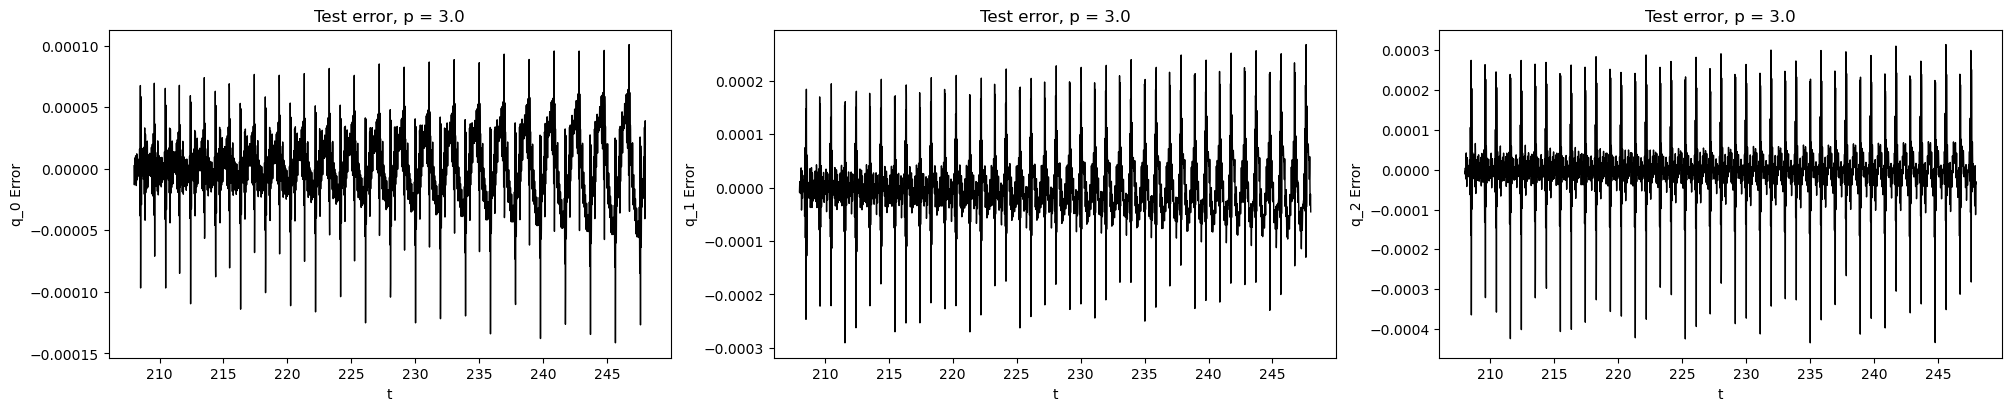

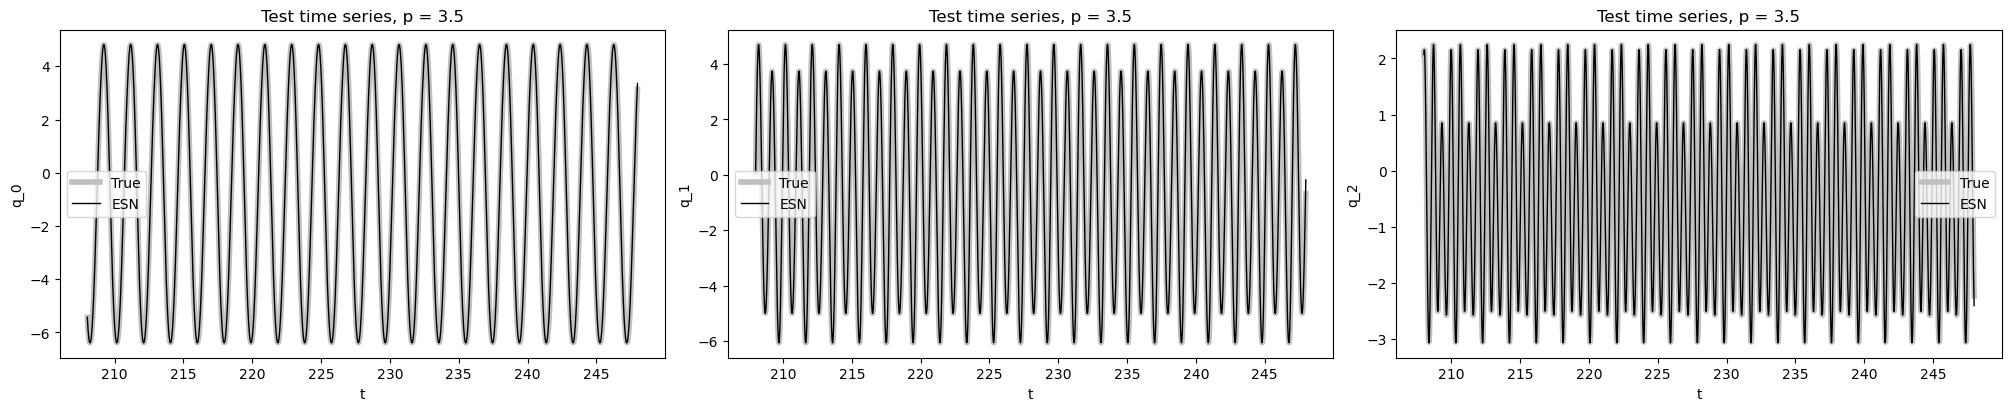

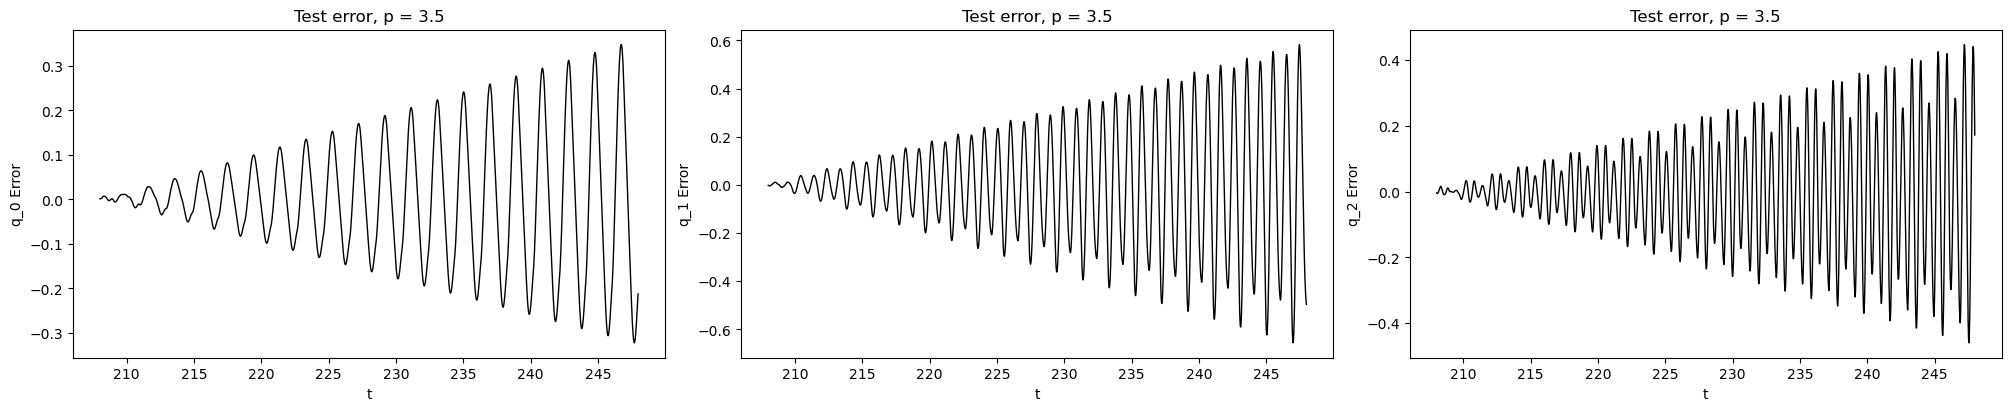

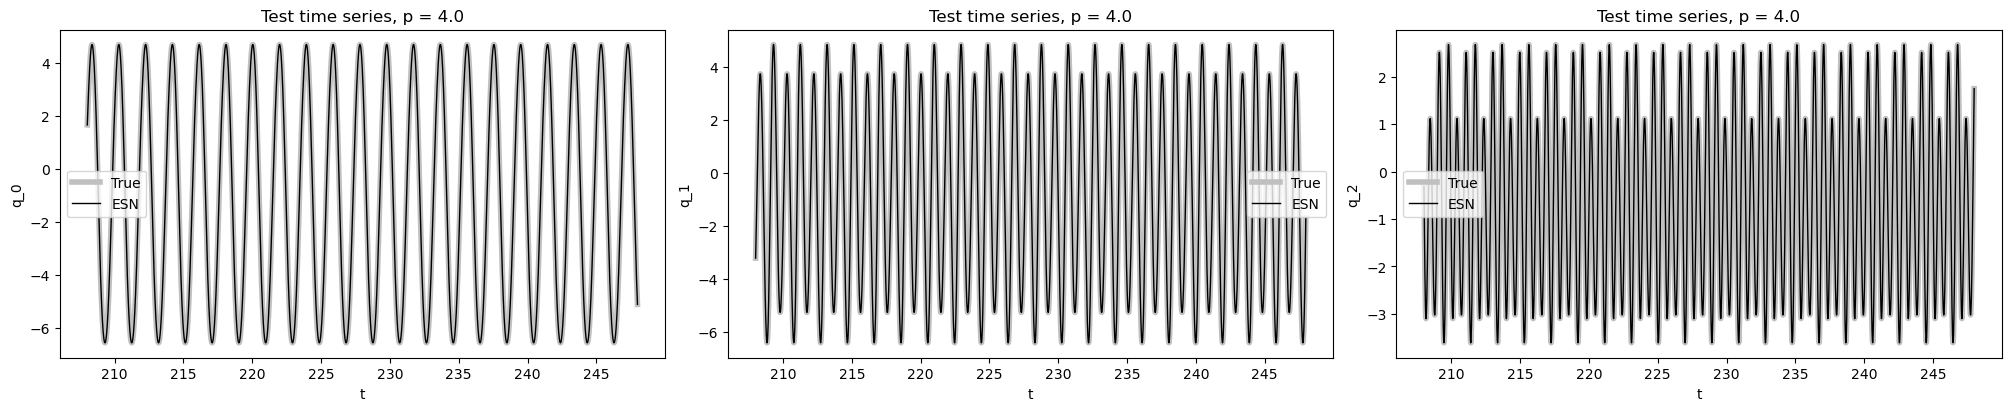

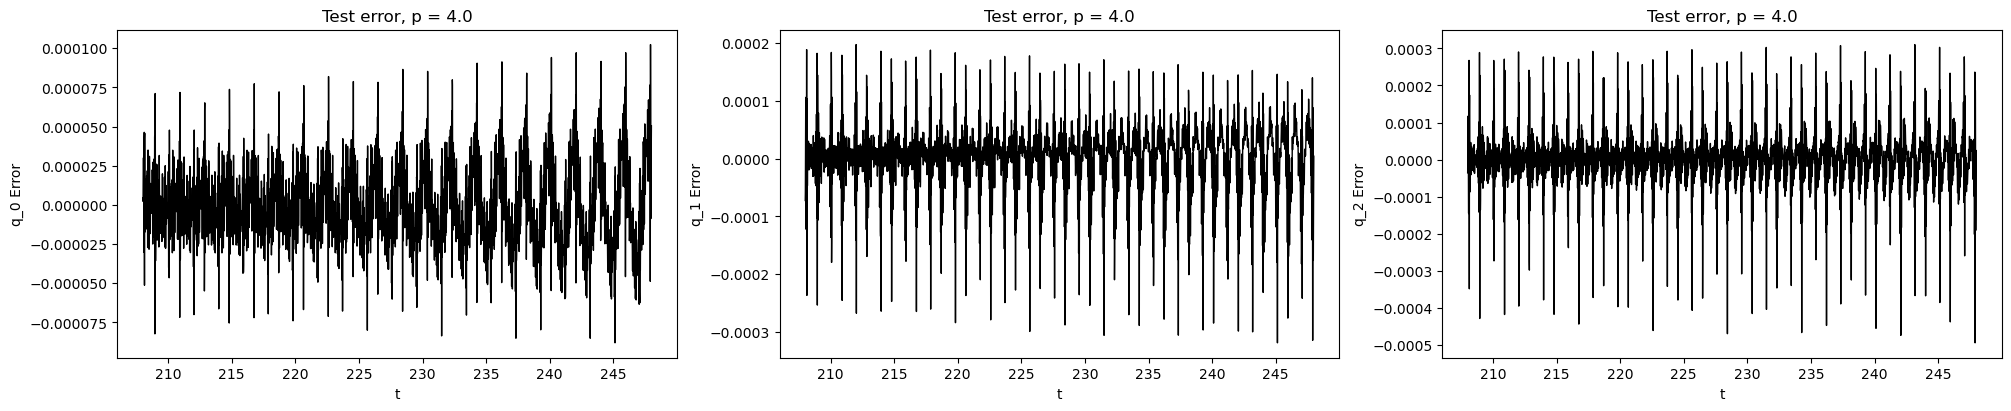

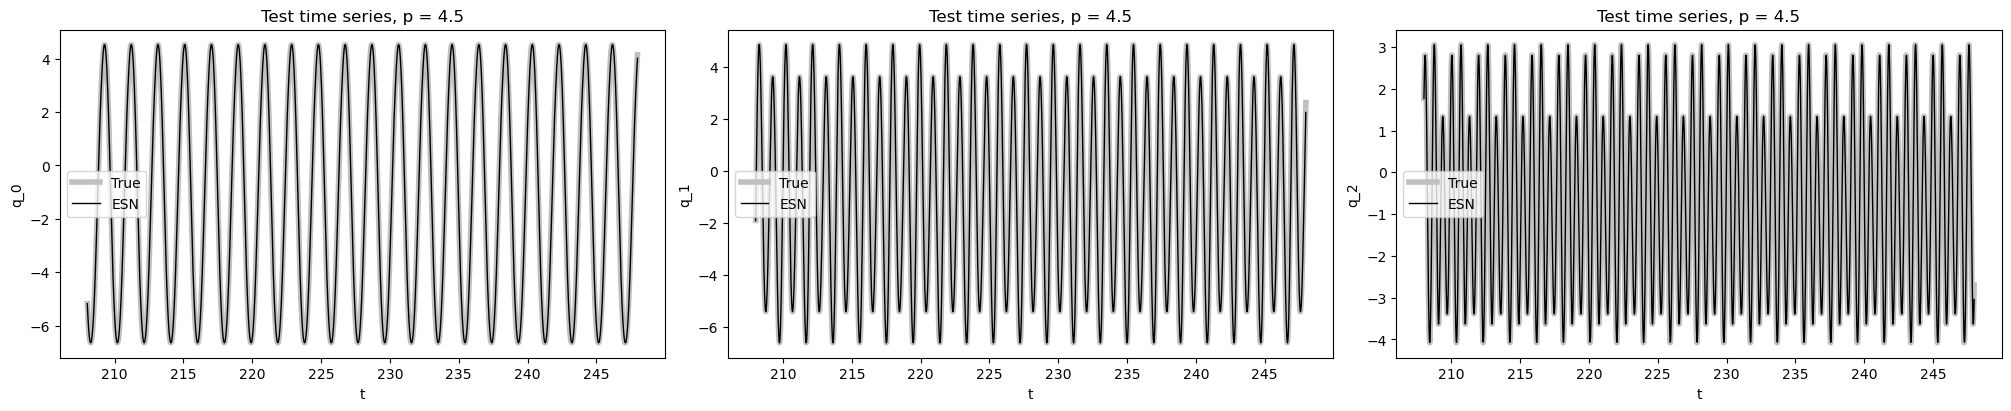

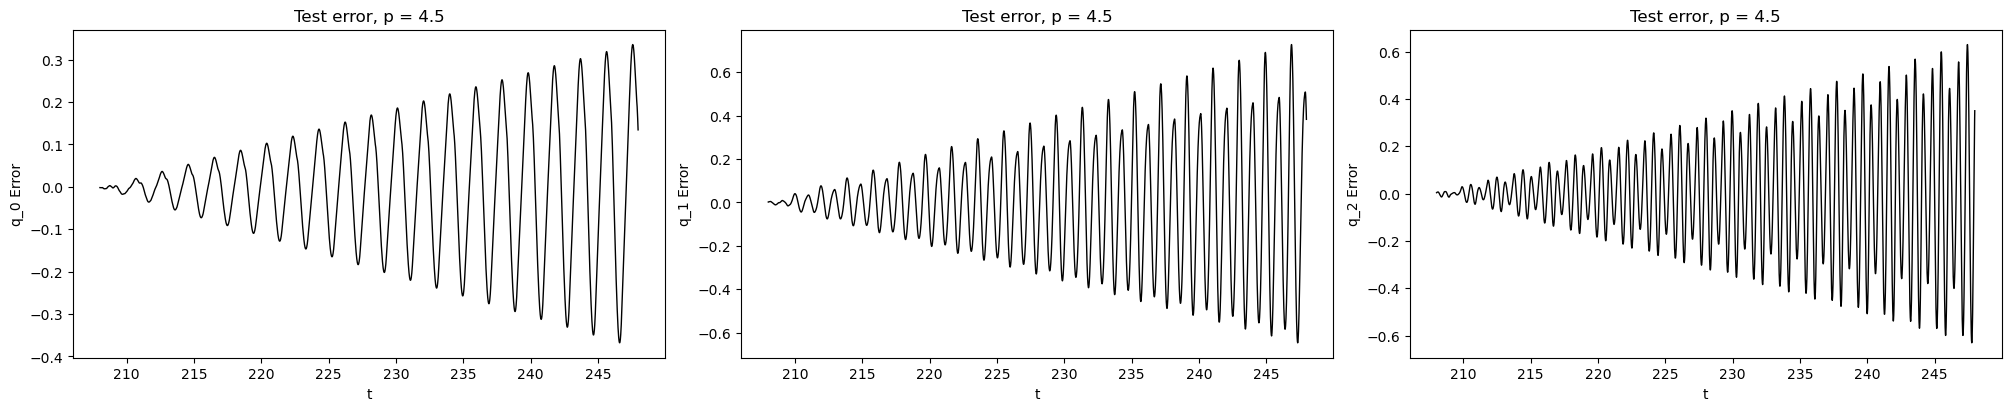

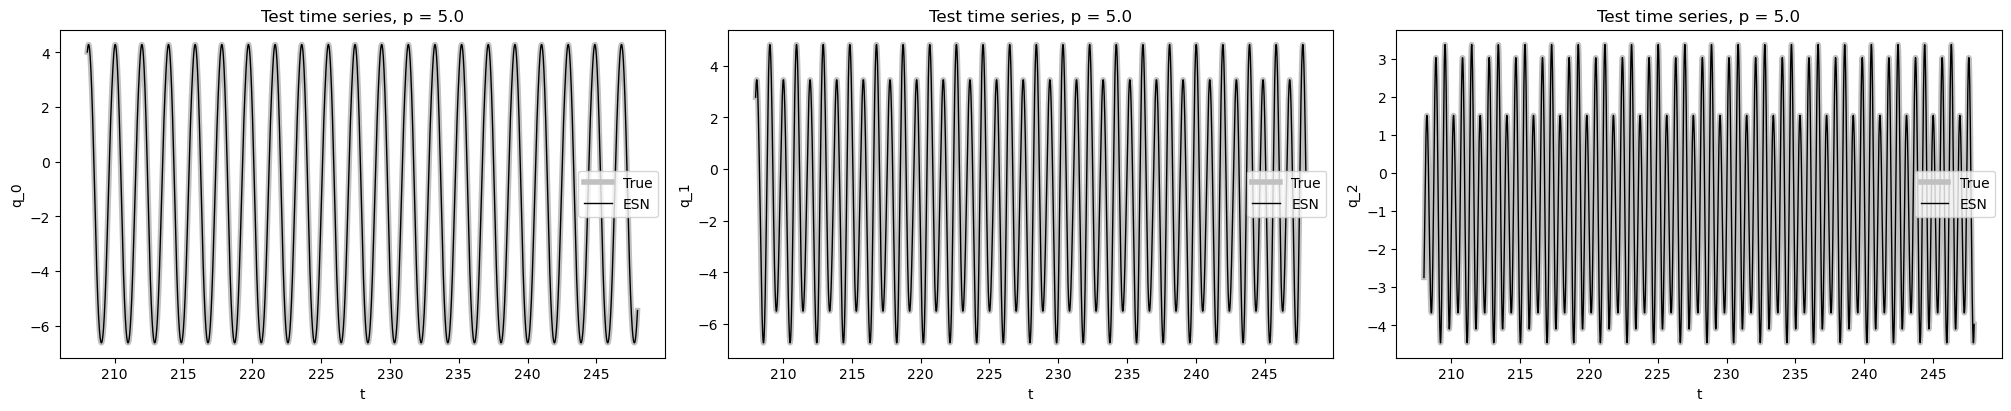

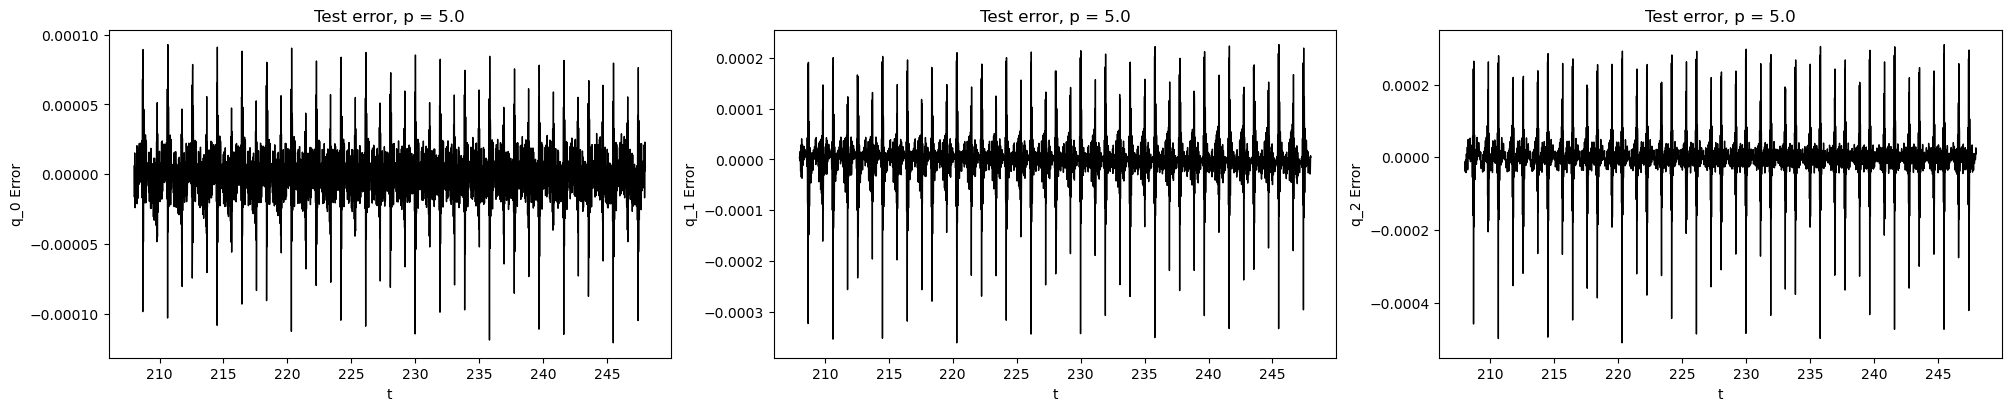

In [10]:
plt_idx = [0,1,2]
Y_pred_train = [None]*len_p_list
for p_idx in range(len_p_list):
    _, Y_pred_train_ = my_ESN.closed_loop_with_washout(U_washout = U_washout_train[p_idx], N_t = len(U_train[p_idx]), P_washout=P_washout_train[p_idx], P = P_train[p_idx])
    Y_pred_train[p_idx] = Y_pred_train_[1:,:]
    plt.figure(figsize=(20,4), constrained_layout = True)
    for j, k in enumerate(plt_idx):
        plt.subplot(1,len(plt_idx),j+1)
        plt.plot(t_train[p_idx], Y_train[p_idx][:,k],color="silver",linewidth=2)
        plt.plot(t_train[p_idx], Y_pred_train[p_idx][:,k],color="black",linewidth=0.5)
        plt.title(f"Training time series, p = {p_list[p_idx]}")
        plt.xlabel("t")
        plt.ylabel(f"q_{j}")
        plt.legend(["True", "ESN"])
    
    plt.figure(figsize=(20,4), constrained_layout = True)
    for j, k in enumerate(plt_idx):
        plt.subplot(1,len(plt_idx),j+1)
        plt.plot(t_train[p_idx], Y_train[p_idx][:,k]-Y_pred_train[p_idx][:,k],color="black",linewidth=0.5)
        plt.title(f"Training error, p = {p_list[p_idx]}")
        plt.xlabel("t")
        plt.ylabel(f"q_{j} Error")

Y_pred_val = [None]*len_p_list
for p_idx in range(len_p_list):
    _, Y_pred_val_ = my_ESN.closed_loop_with_washout(U_washout = U_washout_val[p_idx], N_t = len(U_val[p_idx]), P_washout=P_washout_val[p_idx], P = P_val[p_idx])
    Y_pred_val[p_idx] = Y_pred_val_[1:,:]
    plt.figure(figsize=(20,4), constrained_layout = True)
    for j, k in enumerate(plt_idx):
        plt.subplot(1,len(plt_idx),j+1)
        plt.plot(t_val[p_idx][:], Y_val[p_idx][:,k],color="silver",linewidth=4)
        plt.plot(t_val[p_idx][:], Y_pred_val[p_idx][:,k],color="black",linewidth=1)
        plt.title(f"Test time series, p = {p_list[p_idx]}")
        plt.xlabel("t")
        plt.ylabel(f"q_{j}")
        plt.legend(["True", "ESN"])

    plt.figure(figsize=(20,4), constrained_layout = True)
    for j, k in enumerate(plt_idx):
        plt.subplot(1,len(plt_idx),j+1)
        plt.plot(t_val[p_idx][:], Y_val[p_idx][:,k]-Y_pred_val[p_idx][:,k],color="black",linewidth=1)
        plt.title(f"Test error, p = {p_list[p_idx]}")
        plt.xlabel("t")
        plt.ylabel(f"q_{j} Error")

# calculate error
for p_idx in range(len_p_list):
    train_error = rmse(Y_train[p_idx], Y_pred_train[p_idx])
    val_error = rmse(Y_val[p_idx], Y_pred_val[p_idx])
    print("Train error: ", train_error)
    print("Validation error: ", val_error)

In [ ]:
sim_dict2 = {"t_sim_len": 500,
            "data_dt": 1e-2,
            "dt": 1e-2,
            "t_transient_len": 200,
            "t_washout_len": 5,
            "t_train_len": 50,
            "t_val_len": 20,
            }
pp_test_list = np.arange(0.5,1.0,0.1)
plt_t_idx = 0
#plt.figure(figsize=(12,14), constrained_layout = True)
for test_idx, pp_test in enumerate(pp_test_list): 
    if param == "beta":
        beta_test = pp_test
        print("Beta:", beta_test)
        tau_test = 0.2
    elif param == "tau":
        tau_test = pp_test
        print("Tau:", tau_test)
        beta_test = 1.2

    beta_name = f'{beta_test:.2f}'
    beta_name = beta_name.replace(".","_")
    tau_name = f'{tau_test:.2f}'
    tau_name = tau_name.replace(".","_")
    data_path = f"data_new/rijke_kings_poly_N_g_4_beta_{beta_name}_tau_{tau_name}.h5"

    U_washout_test, U_test, Y_test, t_test, U_washout_testval, U_testval, Y_testval, t_testval = load_data_sys(beta=beta_test,tau=tau_test,N_g=N_g,**sim_dict2,data_path=data_path)
    P_test = pp_test*np.ones((len(U_test),1))
    P_testval = pp_test*np.ones((len(U_testval),1))
    P_washout_test = pp_test*np.ones((len(U_washout_test),1))
    P_washout_testval = pp_test*np.ones((len(U_washout_testval),1))
    X_pred_test, Y_pred_test = my_ESN.closed_loop_with_washout(U_washout = U_washout_test, N_t = len(U_test), P_washout=P_washout_test, P = P_test)
    Y_pred_test = Y_pred_test[1:,:]

    X_pred_testval, Y_pred_testval = my_ESN.closed_loop_with_washout(U_washout = U_washout_testval, N_t = len(U_testval), P_washout=P_washout_testval, P = P_testval)
    Y_pred_testval = Y_pred_testval[1:,:]
    plt.figure(figsize=(16,4))
    for j, k in enumerate(plt_idx):
        plt.subplot(1,len(plt_idx),j+1)
        plt.plot(t_test[plt_t_idx:], Y_test[plt_t_idx:,k],color="silver",linewidth=2)
        plt.plot(t_test[plt_t_idx:], Y_pred_test[plt_t_idx:,k],color="black",linewidth=0.5)
        plt.title(f"Test time series, p = {pp_test:4.2f}")
        plt.xlabel("t")
        plt.ylabel(f"q_{j}")
        plt.legend(["True", "ESN"])

    plt.figure(figsize=(6,4), constrained_layout = True)
    plt.plot(Y_test[plt_t_idx:,0], Y_test[plt_t_idx:,1],color="silver",linewidth=2)
    plt.plot(Y_pred_test[plt_t_idx:,0], Y_pred_test[plt_t_idx:,1],color="black",linewidth=0.5)
    plt.title(f"Test time series, p = {pp_test:4.2f}")
    plt.xlabel("x")
    plt.ylabel(f"y")
    plt.legend(["True", "ESN"])

    test_error = rmse(Y_test, Y_pred_test)
    testval_error = rmse(Y_testval, Y_pred_testval)
    print("Train error: ", test_error)
    print("Validation error: ", testval_error)

In [ ]:
from scipy import stats
par = np.arange(3.0,8.0,0.2)     # new parameter
N_washout_test = 500
N_test = 100000

local_maxx=[None]*len(par)
print('prediction started')

sim_test_dict = {"t_sim_len": 1200,
            "data_dt": 1e-2,
            "dt": 1e-2,
            "t_transient_len": 0,
            "t_washout_len": 0,
            "t_train_len": 1000,
            "t_val_len": 0,
            }
plt_idx_list = [0,1,2,3,4,5,6,7,8]

for ind_par in range(len(par)):
    fig = plt.figure(figsize=(20,8), constrained_layout=True)
    U_init = np.zeros(dim)
    U_init[0] = 1.0
    U_washout_test = np.tile(U_init, (N_washout_test,1))
    P_test = par[ind_par]*np.ones((N_test,1))
    P_washout_test = par[ind_par]*np.ones((N_washout_test,1))
    _, Y_pred_data = my_ESN.closed_loop_with_washout(U_washout = U_washout_test, N_t = N_test-1, P_washout=P_washout_test, P = P_test)
    pred_data = Y_pred_data[20000:,:]

    if param == "beta":
        beta_test = par[ind_par]
        print("Beta:", beta_test)
        tau_test = 0.2
    elif param == "tau":
        tau_test = par[ind_par]
        print("Tau:", tau_test)
        beta_test = 1.2

    print(par[ind_par])
    beta_name = f'{beta_test:.2f}'
    beta_name = beta_name.replace(".","_")
    tau_name = f'{tau_test:.2f}'
    tau_name = tau_name.replace(".","_")
    data_path = f"data_new/rijke_kings_poly_N_g_4_beta_{beta_name}_tau_{tau_name}.h5"
    #data_path = None
    _, _, Y_data, t, _, _, _, _ = load_data_sys(beta=beta_test,tau=tau_test,N_g=N_g,**sim_test_dict, data_path=data_path)
    true_data = Y_data[20000:N_test,:]


    bin_size = 100
    lw = 3
    fs = 12
    for plt_idx in plt_idx_list:
        ax = plt.subplot(2,5,plt_idx+1)
        true_density = stats.gaussian_kde(true_data[:,plt_idx]) 
        n, x, _ = plt.hist(true_data[:,plt_idx], bins=bin_size, color='white', histtype=u'step',
                            density=True, orientation='horizontal')
        pred_density = stats.gaussian_kde(pred_data[:,plt_idx])
        n, x_pred, _ = plt.hist(pred_data[:,plt_idx], bins=bin_size, color='white',
                                histtype=u'step', density=True, orientation='horizontal')
        ax.plot(x, true_density(x), 'k', linewidth=lw, label='Reference')
        ax.plot(x_pred, pred_density(x_pred), 'r--', linewidth=lw, label='ESN')
        ax.set_title(f"q_{plt_idx}")
        ax.set_xlim(min(x)*1.1, max(x)*1.1)
        ax.set_ylim(-0.1, (max(true_density(x).max(), pred_density(x_pred).max())*1.1))
        #ax.set_aspect(1./ax.get_data_ratio())
        # ax.set_yticklabels([])
        ax.grid(True, c='lightgray', linestyle='--', linewidth=0.5)
    fig.suptitle(f"beta = {par[ind_par]}")

In [63]:
# #--------prediction for a new parameter--------------------------------------------------------------------
par = np.arange(0.2,9.0,0.2)     # new parameter
N_washout_test = 500
N_test = 30000

local_maxx=[None]*len(par)
print('prediction started')
for ind_par in range(len(par)):
    U_init = np.zeros(dim)
    U_init[0] = 1.0
    U_washout_test = np.tile(U_init, (N_washout_test,1))
    P_test = par[ind_par]*np.ones((N_test,1))
    P_washout_test = par[ind_par]*np.ones((N_washout_test,1))
    _, Y_pred_data = my_ESN.closed_loop_with_washout(U_washout = U_washout_test, N_t = N_test-1, P_washout=P_washout_test, P = P_test)
    pred_data = Y_pred_data[10000:,0]

    aa = []
    aa_idx = []
    for ind_pred_data in range(len(pred_data)-2):
            
        if pred_data[ind_pred_data+2]-pred_data[ind_pred_data+1] < 0 and pred_data[ind_pred_data+1]-pred_data[ind_pred_data] > 0:
            aa = np.append(aa, pred_data[ind_pred_data+1])
            aa_idx = np.append(aa_idx, ind_pred_data)
            
    if pred_data[-2]-pred_data[-3] < 10**-3:
        aa = np.append(aa,pred_data[-2])
        aa_idx = np.append(aa_idx, ind_pred_data)
                
    local_maxx[ind_par] = aa

    #plt.figure(figsize=(15,4))
    #plt.plot(pred_data)
    #plt.plot(aa_idx,aa,'ro')

prediction started


In [45]:
par = np.arange(0.4,9.0,0.2)     # new parameter
local_maxx_true=[None]*len(par)
sim_test_dict = {"t_sim_len": 500,
            "data_dt": 1e-2,
            "dt": 1e-2,
            "t_transient_len": 200,
            "t_washout_len": 0,
            "t_train_len": 300,
            "t_val_len": 0,
            }
for ind_par in range(len(par)):
    if param == "beta":
        beta_test = par[ind_par]
        print("Beta:", beta_test)
        tau_test = 0.2
    elif param == "tau":
        tau_test = par[ind_par]
        print("Tau:", tau_test)
        beta_test = 1.2

    print(par[ind_par])
    _, _, Y_data, t, _, _, _, _ = load_data_sys(beta=beta_test,tau=tau_test,N_g=N_g,**sim_test_dict)
    true_data = Y_data[10000:N_test,0]
    
    bb = []

    for ind_true_data in range(len(true_data)-2):    
        if true_data[ind_true_data+2]-true_data[ind_true_data+1] < 0 and true_data[ind_true_data+1]-true_data[ind_true_data] > 0:
            bb = np.append(bb, true_data[ind_true_data+1])

    # what is the point of this?        
    #if true_data[-2]-true_data[-3] < 10**-3:
    #    bb = np.append(bb,true_data[-2])
                          
    local_maxx_true[ind_par] = bb

Beta: 0.4
0.4
Beta: 0.6000000000000001
0.6000000000000001
Beta: 0.8000000000000002
0.8000000000000002
Beta: 1.0000000000000002
1.0000000000000002
Beta: 1.2000000000000002
1.2000000000000002
Beta: 1.4000000000000004
1.4000000000000004
Beta: 1.6000000000000005
1.6000000000000005
Beta: 1.8000000000000003
1.8000000000000003
Beta: 2.0000000000000004
2.0000000000000004
Beta: 2.2000000000000006
2.2000000000000006
Beta: 2.400000000000001
2.400000000000001
Beta: 2.6000000000000005
2.6000000000000005
Beta: 2.8000000000000007
2.8000000000000007
Beta: 3.000000000000001
3.000000000000001
Beta: 3.2000000000000006
3.2000000000000006
Beta: 3.400000000000001
3.400000000000001
Beta: 3.600000000000001
3.600000000000001
Beta: 3.800000000000001
3.800000000000001
Beta: 4.000000000000002
4.000000000000002
Beta: 4.200000000000001
4.200000000000001
Beta: 4.400000000000002
4.400000000000002
Beta: 4.600000000000001
4.600000000000001
Beta: 4.800000000000002
4.800000000000002
Beta: 5.000000000000002
5.000000000000

NameError: name 'local_maxx_true' is not defined

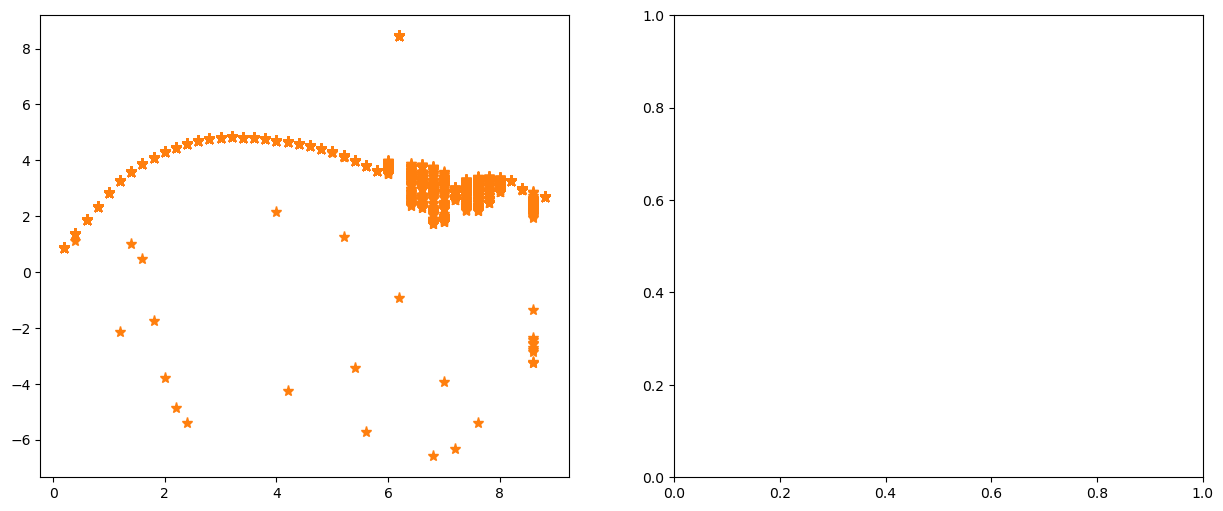

In [170]:
# bifurcation diagram
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

for ind_par in range(len(par)):
   plot_local_maxx=local_maxx[ind_par]  
   ax[0].plot(par[ind_par]*np.ones(len(plot_local_maxx)), plot_local_maxx, color='tab:orange', marker='*', linestyle='None',
                                       linewidth=3, markersize=8)

for ind_par in range(len(par)): 
    plot_local_maxx=local_maxx_true[ind_par]  
    ax[1].plot(par[ind_par]*np.ones(len(plot_local_maxx)), plot_local_maxx, color='tab:blue', marker='*', linestyle='None',
                                        linewidth=3, markersize=8)


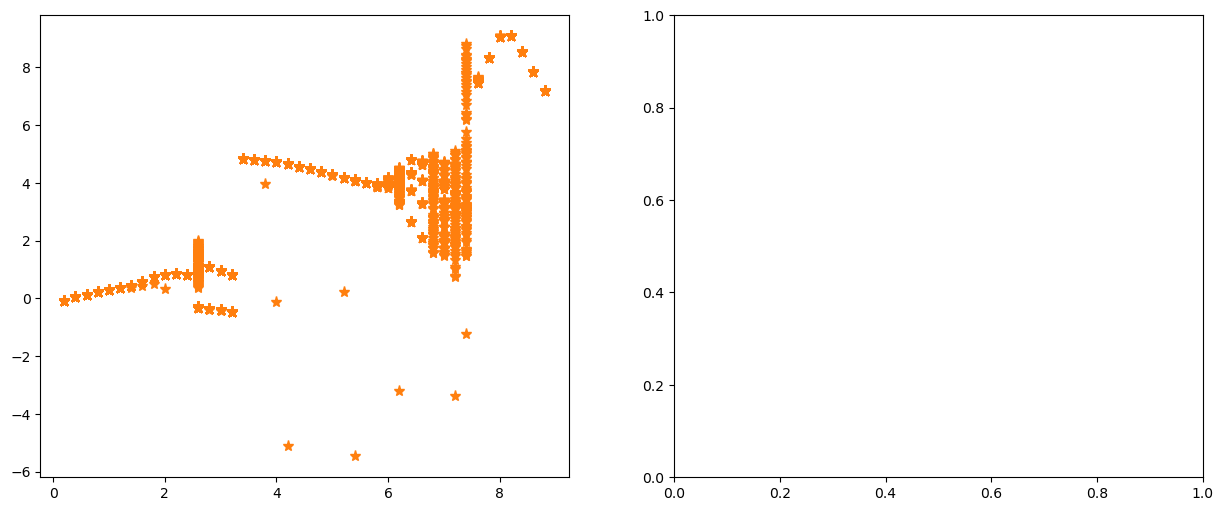

In [64]:
# bifurcation diagram
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

for ind_par in range(len(par)):
   plot_local_maxx=local_maxx[ind_par]  
   ax[0].plot(par[ind_par]*np.ones(len(plot_local_maxx)), plot_local_maxx, color='tab:orange', marker='*', linestyle='None',
                                       linewidth=3, markersize=8)


In [12]:
def run_true_grad(my_rijke, t_bar, y_bar, data_dt, dt):
    # direct problem
    #dir0 = np.zeros(2*my_rijke.N_dim+2)
    #dir = odeint(my_rijke.direct_ode,dir0,t_bar,args=(t_bar,1/data_dt,y_bar),tfirst= True)
    #dJ_dp_dir = 1/t_bar[-1]*dir[-1,-2]
    dJ_dp_dir = 0
    
    # adjoint problem
    #adjT = np.zeros(my_rijke.N_dim+2)
    #adj = odeint(my_rijke.adjoint_ode,adjT,np.flip(t_bar),args =(t_bar,1/data_dt,y_bar),tfirst= True)
    #dJ_dp_adj  = 1/t_bar[-1]*adj[-1,-2]
    #plt.figure()
    #plt.plot(t_bar[1:],1/t_bar[1:]*adj[1:,-2])
    #plt.xlabel("t")
    #plt.title("dJ/dbeta")
    #plt.figure()
    #plt.plot(t_bar[1:],1/t_bar[1:]*adj[1:,-1])
    #plt.title("dJ/dtau")
    dJ_dp_adj = 0
    
    # Calculate numerically
    # Find perturbed solutions (in beta)
    h = 1e-5 # perturbation on the parameter
    upsample = int(np.round(data_dt/dt))
    J_beta = 1/4*np.mean(np.sum(y_bar[::upsample,0:2*my_rijke.N_g]**2, axis = 1))
    
    # left solution with beta = beta-h
    my_rijke_beta_left = Rijke(N_g=my_rijke.N_g,N_c=my_rijke.N_c,c_1=0.1,c_2=0.06,beta=my_rijke.beta-h,x_f=0.2,tau=my_rijke.tau,
                     heat_law="kings_poly",damping="modal")

    y_bar_beta_left = odeint(my_rijke_beta_left.ode,y_bar[0,:],t_bar,tfirst = True)
    J_beta_left = 1/4*np.mean(np.sum(y_bar_beta_left[::upsample,0:2*my_rijke_beta_left.N_g]**2, axis = 1))
        
    # right solution with beta = beta+h
    my_rijke_beta_right = Rijke(N_g=my_rijke.N_g,N_c=my_rijke.N_c,c_1=0.1,c_2=0.06,beta=my_rijke.beta+h,x_f=0.2,tau=my_rijke.tau,
                     heat_law="kings_poly",damping="modal")
    
    y_bar_beta_right = odeint(my_rijke_beta_right.ode,y_bar[0,:],t_bar,tfirst = True)
    J_beta_right = 1/4*np.mean(np.sum(y_bar_beta_right[::upsample,0:2*my_rijke_beta_right.N_g]**2, axis = 1))
    dJ_dp_num = (J_beta_right-J_beta_left)/(2*h)
    # dJ_dp_num = (J_beta_right-J_beta)/(h) 
    #dJ_dp_num = 0
    print("J = ", J_beta)
    print("J left = ",J_beta_left)
    print("J right = ",J_beta_right)

    #print("dJ/dp direct = ", dJ_dp_dir)
    #print("dJ/dp adjoint = ", dJ_dp_adj)
    print("dJ/dp numerical = ", dJ_dp_num)

    return dJ_dp_dir,dJ_dp_adj,dJ_dp_num

def run_esn_grad(my_ESN, N, X_pred_grad, Y_pred_grad, P_grad):
    # OBJECTIVE SQUARED L2 OF OUTPUT STATES (ACOUSTIC ENERGY)
    # calculate gradient for a timeseries, direct method
    # time averaged objective
    # q = np.zeros((my_ESN.N_reservoir, my_ESN.N_param_dim))
    # q_prev = np.zeros((my_ESN.N_reservoir, my_ESN.N_param_dim))
    dJ_dp_dir = np.zeros(my_ESN.N_param_dim)
    # for i in np.arange(1,N):
    #     q = my_ESN.drdp(X_pred_grad[i,:]).toarray()+np.dot(my_ESN.jac(X_pred_grad[i,:]).toarray(),q_prev)
    #     q_prev = q 
    #     X_pred_aug = np.hstack((X_pred_grad[i,:], my_ESN.b_out))
    #     dJ_dr = (1/N)*1/2*np.dot(np.dot(X_pred_aug,my_ESN.W_out),my_ESN.W_out[: my_ESN.N_reservoir, :].T)
    #     #dJ_dr2 = (1/N)*2*np.einsum("r, rb, bn -> n", X_pred_aug,my_ESN.W_out,my_ESN.W_out[: my_ESN.N_reservoir, :].T)
    #     dJ_dp_dir += np.dot(dJ_dr,q)
# 
    # # calculate gradient for a timeseries, adjoint method
    # time averaged objective
    # X_pred_aug = np.hstack((X_pred_grad[N - 1, :], my_ESN.b_out))
    # v_prev = (
    #     (1 / N)
    #     * 1
    #     / 2
    #     * np.dot(
    #         np.dot(X_pred_aug, my_ESN.W_out[:,:20]), my_ESN.W_out[: my_ESN.N_reservoir, :20].T
    #     ).T
    # )
    dJ_dp_adj = np.zeros(my_ESN.N_param_dim)
    # for i in np.arange(N - 1, 0, -1):
    #     dJ_dp_adj += np.dot(my_ESN.drdp(X_pred_grad[i, :]).toarray().T, v_prev)
    #     X_pred_aug = np.hstack((X_pred_grad[i - 1, :], my_ESN.b_out))
    #     dJ_dr = (
    #         (1 / N)
    #         * 1
    #         / 2
    #         * np.dot(
    #             np.dot(X_pred_aug, my_ESN.W_out[:,:20]),
    #             my_ESN.W_out[: my_ESN.N_reservoir, :20].T,
    #         ).T
    #     )
    #     v = np.dot(my_ESN.jac(X_pred_grad[i, :]).T, v_prev) + dJ_dr
    #     v_prev = v

    # calculate gradient for a timeseries, numerical method
    # time averaged objective 
    h = 1e-5
    J = 1/4*np.mean(np.sum(Y_pred_grad[:,0:2*N_g]**2, axis = 1))
    
    dJ_dp_num = np.zeros((my_ESN.N_param_dim))
    for i in range(my_ESN.N_param_dim):
        P_left = P_grad.copy()
        P_left[:,i] -= h
        P_right = P_grad.copy()
        P_right[:,i] += h
        X_left, Y_left = my_ESN.closed_loop(X_pred_grad[0,:], N-1, P_left)
        X_right, Y_right =  my_ESN.closed_loop(X_pred_grad[0,:], N-1, P_right)
        J_left = 1/4*np.mean(np.sum(Y_left[:,0:2*N_g]**2, axis = 1))
        J_right = 1/4*np.mean(np.sum(Y_right[:,0:2*N_g]**2, axis = 1))
        dJ_dp_num[i] = (J_right-J_left)/(2*h)
    print("J ESN = ", J)
    print("J left ESN = ",J_left)
    print("J right ESN = ",J_right)

    #print("dJ/dp direct ESN = ", dJ_dp_dir)
    print("dJ/dp adjoint ESN = ", dJ_dp_adj)
    print("dJ/dp numerical ESN = ", dJ_dp_num)
    return dJ_dp_dir,dJ_dp_adj,dJ_dp_num

In [42]:
my_p_list = np.arange(0.3,5.8,0.1)
n_esns = 5
#my_p_list = np.array([1.3])
#my_p_list = np.array([1.2])
dJ_dp_dir_true = len(my_p_list)*[None]
dJ_dp_adj_true = len(my_p_list)*[None]
dJ_dp_num_true = len(my_p_list)*[None]
dJ_dp_dir_esn = len(my_p_list)*[None]
dJ_dp_adj_esn = len(my_p_list)*[None]
dJ_dp_num_esn = [[0 for i in range(len(my_p_list))] for j in range(n_esns)]
J_bar = np.zeros(len(my_p_list))
J_esn = np.zeros(len(my_p_list))

sim_dict3 = {"t_sim_len": 1200,
            "data_dt": 1e-2,
            "dt": 1e-2,
            "t_transient_len": 200,
            "t_washout_len": 5,
            "t_train_len": 600,
            "t_val_len": 0,
            }
for esn_idx in range(n_esns):
    my_ESN = ESN(reservoir_size = 1200, 
            dimension = dim, 
            parameter_dimension = 1, 
            reservoir_connectivity = 20, 
            spectral_radius = 0.75460178,    
            input_scaling = 0.68803003,
            leak_factor = 0.15127487,
            input_bias = np.array([]),
            output_bias = np.array([]),
            input_normalization = scale, 
            parameter_normalization=[np.array([8.88043705]),np.array([5.1122118])],
            r2_mode=True,
            verbose=False)
    my_ESN.train(U_washout_train, U_train, Y_train, tikhonov = 1e-3, P_washout=P_washout_train, P_train=P_train, train_idx_list=[0,2,4,6,8])

    for p_idx, my_p in enumerate(my_p_list):
        if param == "beta":
            beta_grad = my_p
            print("Beta:", beta_grad)
            tau_grad = 0.2
        elif param == "tau":
            tau_grad = my_p
            print("Tau:", tau_grad)
            beta_grad= 1.2

        beta_name = f'{beta_grad:.2f}'
        beta_name = beta_name.replace(".","_")
        tau_name = f'{tau_grad:.2f}'
        tau_name = tau_name.replace(".","_")
        data_path = f"data_new/rijke_kings_poly_N_g_4_beta_{beta_name}_tau_{tau_name}.h5"
        #data_path = None
        y_sim, U_sim, t_sim = run_rijke_sim(beta_grad,tau_grad,N_g,sim_dict3["t_sim_len"],sim_dict3["data_dt"], data_path = data_path)

        U_washout, U_grad, Y_grad, t_grad, _, _, _, _ = create_dataset(U_sim,t_sim,
                    sim_dict3["dt"],
                    sim_dict3["t_transient_len"],
                    sim_dict3["t_washout_len"],
                    sim_dict3["t_train_len"],
                    sim_dict3["t_val_len"])
        
        P_grad = my_p*np.ones((len(U_grad),1))
        P_washout = my_p*np.ones((len(U_washout),1))

        my_rijke = Rijke(N_g=N_g,N_c=10,c_1=0.1,c_2=0.06,beta=beta_grad,x_f=0.2,tau=tau_grad,
                        heat_law="kings_poly",damping="modal")
        if data_path is None:
            N_transient = int(np.round(sim_dict3["t_transient_len"]/sim_dict3["data_dt"]))
            y_bar = y_sim[N_transient:,:]
            t_bar = t_sim[N_transient:]

            N_washout = int(np.round(sim_dict3["t_washout_len"]/sim_dict3["data_dt"]))
            y_bar = y_bar[N_washout:,:]
            t_bar = t_bar[N_washout:]-t_bar[N_washout]
            dJ_dp_dir_true[p_idx],dJ_dp_adj_true[p_idx],dJ_dp_num_true[p_idx] = run_true_grad(my_rijke, t_bar, y_bar, sim_dict3["data_dt"], sim_dict3["dt"])
        else:
            data_dict = pp.read_h5(data_path)
            dJ_dp_adj_true[p_idx] = data_dict["dJ_dbeta"]
            print("dJ/dp true = ", dJ_dp_adj_true[p_idx])
            #dJ_dtau = data_dict["dJ_dtau"]

        X_pred_grad, Y_pred_grad = my_ESN.closed_loop_with_washout(U_washout = U_washout, N_t = len(U_grad)-1, P_washout=P_washout, P = P_grad)
        N = len(U_grad)
        J_esn[p_idx] = 1/4*np.mean(np.sum(Y_pred_grad[:,0:2*my_rijke.N_g]**2, axis = 1))
        _,_,dJ_dp_num_esn[esn_idx][p_idx] = run_esn_grad(my_ESN, N, X_pred_grad, Y_pred_grad, P_grad)
#dJ_dp_dir_true = np.array([item for item in dJ_dp_dir_true])
#dJ_dp_adj_true = np.array([item for item in dJ_dp_adj_true])
dJ_dp_num_true = np.array([item for item in dJ_dp_num_true])
#dJ_dp_dir_esn = np.array([item for sublist in dJ_dp_dir_esn for item in sublist])
#dJ_dp_adj_esn = np.array([item for sublist in dJ_dp_adj_esn for item in sublist])
#dJ_dp_num_esn = np.array([item for sublist in dJ_dp_num_esn for item in sublist])
for esn_idx in range(n_esns):
    dJ_dp_num_esn[esn_idx] = np.array([item for sublist in dJ_dp_num_esn[esn_idx] for item in sublist])
dJ_dp_num_esn = np.array(dJ_dp_num_esn)    

Beta: 0.3
dJ/dp true =  3.933308594238387e-09
J ESN =  1.2065396771971995
J left ESN =  1.2065056489029788
J right ESN =  1.206573632944886
dJ/dp adjoint ESN =  [0.]
dJ/dp numerical ESN =  [3.3992021]
Beta: 0.4
dJ/dp true =  3.1315564818144067e-06
J ESN =  1.4348372997189922
J left ESN =  1.4347978312753136
J right ESN =  1.4348765552637073
dJ/dp adjoint ESN =  [0.]
dJ/dp numerical ESN =  [3.93619942]
Beta: 0.5
dJ/dp true =  0.011111277224202366
J ESN =  1.6260662955520204
J left ESN =  1.626101661235233
J right ESN =  1.62603093891864
dJ/dp adjoint ESN =  [0.]
dJ/dp numerical ESN =  [-3.53611583]
Beta: 0.6000000000000001
dJ/dp true =  1.6163591561752968
J ESN =  2.212287624231594
J left ESN =  2.2122439411467916
J right ESN =  2.2123313044238766
dJ/dp adjoint ESN =  [0.]
dJ/dp numerical ESN =  [4.36816385]
Beta: 0.7000000000000002
dJ/dp true =  2.33217255259334
J ESN =  2.5436841543646826
J left ESN =  2.5436576160426934
J right ESN =  2.5437106910188794
dJ/dp adjoint ESN =  [0.]
dJ/d

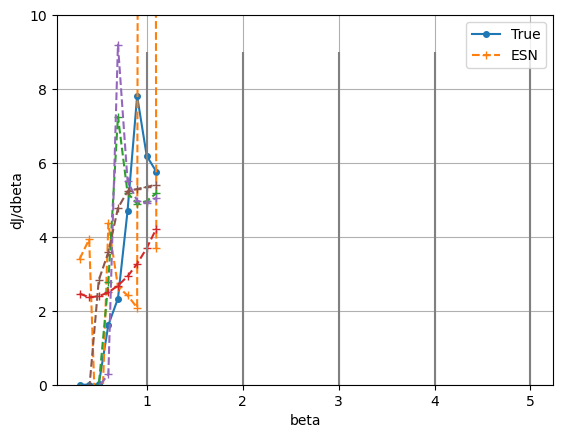

In [43]:
plt.figure()
plt.plot(my_p_list,dJ_dp_adj_true,linestyle = '-',marker = 'o', markersize = 4)
for esn_idx in range(n_esns):
    plt.plot(my_p_list,dJ_dp_num_esn[esn_idx],linestyle = '--',marker = '+')
plt.vlines(np.array(p_list)[0:10:2], ymin=-2, ymax=9, color = "grey")
plt.xlabel("beta")
plt.ylabel("dJ/dbeta")
plt.legend(["True","ESN"])
plt.ylim([0,10])
plt.grid()

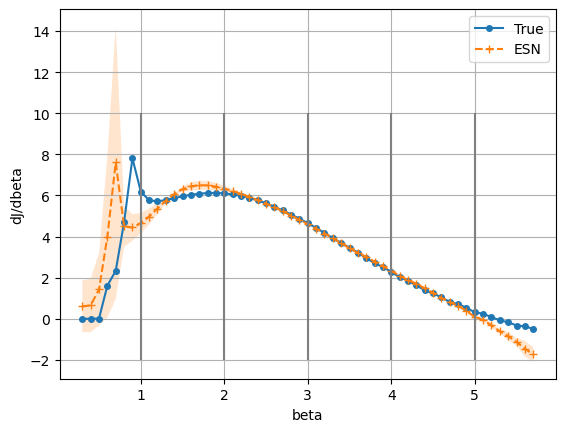

In [35]:
dJ_dp_num_esn_mean = np.mean(dJ_dp_num_esn, axis = 0)
dJ_dp_num_esn_std = np.std(dJ_dp_num_esn, axis = 0)
plt.figure()
plt.plot(my_p_list,dJ_dp_adj_true,linestyle = '-',marker = 'o', markersize = 4)
plt.plot(my_p_list,dJ_dp_num_esn_mean,linestyle = '--',marker = '+')
plt.fill_between(my_p_list, dJ_dp_num_esn_mean-dJ_dp_num_esn_std, dJ_dp_num_esn_mean+dJ_dp_num_esn_std,
    alpha=0.2, facecolor='tab:orange',antialiased=True)
plt.vlines(np.array(p_list)[0:10:2], ymin=-2, ymax=10, color = "grey")
plt.xlabel("beta")
plt.ylabel("dJ/dbeta")
plt.legend(["True","ESN"])
plt.grid()